# Analysis notebook for the thesis

Basic descriptive statistics are adopted from the SWORDS framework. The implementation for Utrecht University can be found here: https://github.com/UtrechtUniversity/SWORDS-UU

- [Analysis notebook for the thesis](#Analysis-notebook-for-the-thesis)
  - [Basic imports and file paths](#Basic-imports-and-file-paths)
  - [Analysis of user collection](#Analysis-of-user-collection)
    - [Load users](#Load-users)
    - [User plots](#User-plots)
    - [User statistics](#User-statistics)
    - [Extra user plots](#Extra-user-plots)
  - [Load and preprocess all other data](#Load-and-preprocess-all-other-data)
    - [Load and merge data](#Load-and-merge-data)
    - [Fill missing data](#Fill-missing-data)
  - [Descriptive statistics and heatmaps](#Descriptive-statistics-and-heatmaps)
    - [Count of repositories in each faculty and repository type](#Count-of-repositories-in-each-faculty-and-repository-type)
      - [Further processing of data](#Further-processing-of-data)
    - [FAIR variables Jaccard similarity](#FAIR-variables-Jaccard-similarity)
    - [Heatmaps for numeric variables](#Heatmaps-for-numeric-variables)
    - [FAIR variables](#FAIR-variables)
    - [Sofware licenses](#Sofware-licenses)
    - [Languages](#Languages)
    - [Topics](#Topics)
    - [Descriptive statistics (table)](#Descriptive-statistics-(table))
    - [Correlation](#Correlation)
  - [Statistical analysis](#Statistical-analysis)
    - [Histograms](#Histograms)
    - [Kruskal-wallis and Dunn's tests](#Kruskal-wallis-and-Dunn's-tests)
    - [Logistic regression](#Logistic-regression)
    - [Random forest](#Random-forest)
    - [Model evaluations](#Model-evaluations)

## Basic imports and file paths
First, configure modules like pandas and plotting libraries.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# statistical imports
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scikit_posthocs as sp
from scipy.spatial import distance
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

Folders and constants

In [2]:
fp_figs = Path("figs")
fp_figs_extra = Path("figs", "extra")
fp_tables= Path("tables")
fp_data = Path("data")

# create output folder if not exists
fp_figs.mkdir(exist_ok=True)
fp_tables.mkdir(exist_ok=True)
fp_figs_extra.mkdir(exist_ok=True)


fp_annotated_users = Path(fp_data, "users_labeled.xlsx")
fp_repos = Path(fp_data, "repositories_labeled_faculty.xlsx")

fp_commits = Path(fp_data, "commits.csv")
fp_contributors = Path(fp_data, "contributors.csv")
fp_howfairis = Path(fp_data, "howfairis.csv")
fp_languages = Path(fp_data, "languages.csv")
fp_readme_variables = Path(fp_data, "readme_variables.csv")
fp_test_paths = Path(fp_data, "test_paths.csv")
fp_topics = Path(fp_data, "topics.csv")
fp_versions = Path(fp_data, "versions.csv")

## Analysis of user collection

### Load users

In [3]:
df_annotated_users = pd.read_excel(fp_annotated_users)

df_annotated_users.head()

,user_id,source,service,date,id,node_id,avatar_url,gravatar_id,url,html_url,...,is_research_group,final_decision,note,employee_type,faculty,level1,level2,level3,level4,position
0,73616e646572,profile_page_uu.csv,github.com,2022-07-13,6605233,MDQ6VXNlcjY2MDUyMzM=,https://avatars.githubusercontent.com/u/660523...,NaN,https://api.github.com/users/73616e646572,https://github.com/73616e646572,...,0.0,1,"Collected via profile pages, therefore must be...",User,Humanities,Humanities,Digital Humanities IT,NaN,NaN,Technical Support Assistant for Teaching and R...
1,a-quei,github_search_users.csv,github.com,2022-07-13,6829836,MDQ6VXNlcjY4Mjk4MzY=,https://avatars.githubusercontent.com/u/682983...,NaN,https://api.github.com/users/a-quei,https://github.com/a-quei,...,0.0,1,0,User,Science,Science,Information and computing sciences,Intelligent Software Systems,Natural Language Processing,Lecturer
2,ajueling,github_search_repos.csv,github.com,2022-07-13,20947797,MDQ6VXNlcjIwOTQ3Nzk3,https://avatars.githubusercontent.com/u/209477...,NaN,https://api.github.com/users/AJueling,https://github.com/AJueling,...,0.0,1,0,User,Science,Science,Physics,Marine and Atmospheric Research,Physical Oceanography,PhD Candidate
3,aldertzomer,github_search_users.csv,github.com,2022-07-13,10392411,MDQ6VXNlcjEwMzkyNDEx,https://avatars.githubusercontent.com/u/103924...,NaN,https://api.github.com/users/aldertzomer,https://github.com/aldertzomer,...,0.0,1,0,User,Veterinary Medicine,Veterinary Medicine,Department Biomolecular Health Sciences,Infectious Diseases & Immunology,Clinical Infectiology,Assistant Professor
4,amices,pure.csv,github.com,2022-07-13,69854869,MDEyOk9yZ2FuaXphdGlvbjY5ODU0ODY5,https://avatars.githubusercontent.com/u/698548...,NaN,https://api.github.com/users/amices,https://github.com/amices,...,1.0,1,0,Organization,Social and Behavioural Sciences,NaN,NaN,NaN,NaN,NaN


### User plots

In [4]:
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams.update({'font.size': 18})

In [5]:
def add_percentages(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height()+.3
        ax.annotate(percentage, (x, y), size = 14)

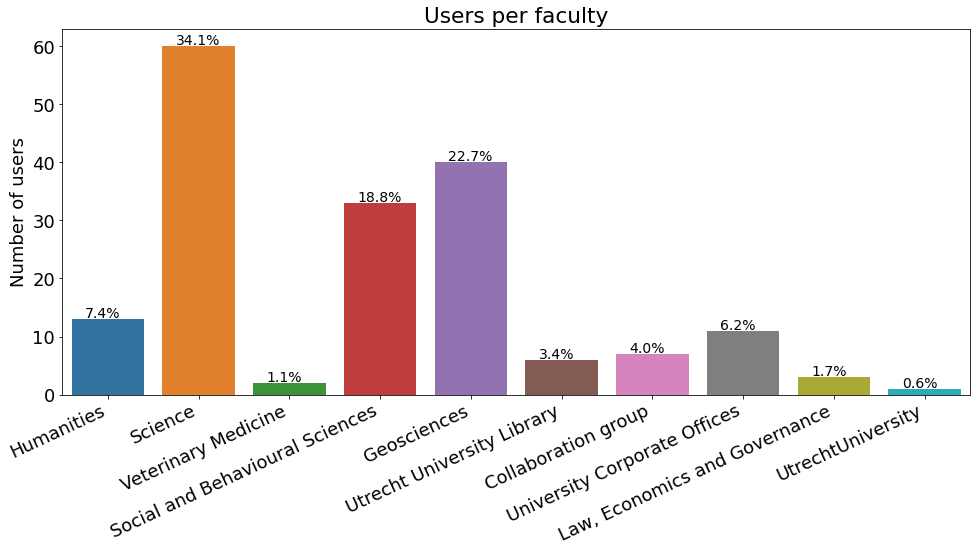

In [6]:
plt.rcParams['figure.figsize'] = [14, 8]
title = "Users per faculty"
s = sns.countplot(x="faculty", data=df_annotated_users)
s.set_xticklabels(s.get_xticklabels(),rotation = 25, ha="right")
s.set(title=title, xlabel=None, ylabel="Number of users")

add_percentages(s, df_annotated_users.faculty)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'user_count.png'))

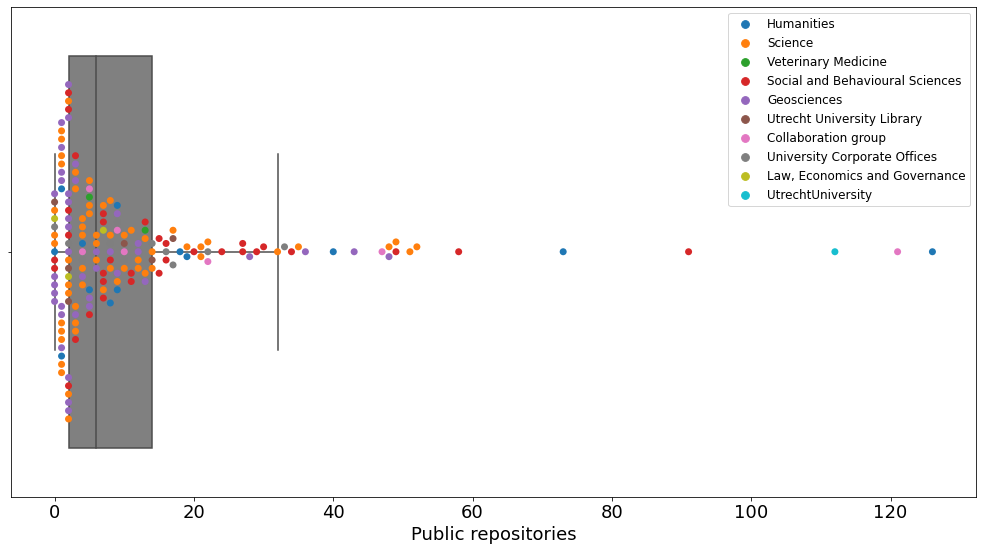

In [7]:
# create a boxplot with swarm
sns.boxplot(x='public_repos', data=df_annotated_users, color=".5", showfliers=False)
s = sns.swarmplot(x='public_repos', y=[""]*len(df_annotated_users), hue="faculty", data=df_annotated_users, size=7)
s.set_xlabel("Public repositories")

plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'user_public_repos.png'))
# df_annotated_users[['user_id', 'public_repos', "faculty", "employee_type"]].loc[df_annotated_users["employee_type"] == "Organization"].sort_values('public_repos', ascending=False).head(10)

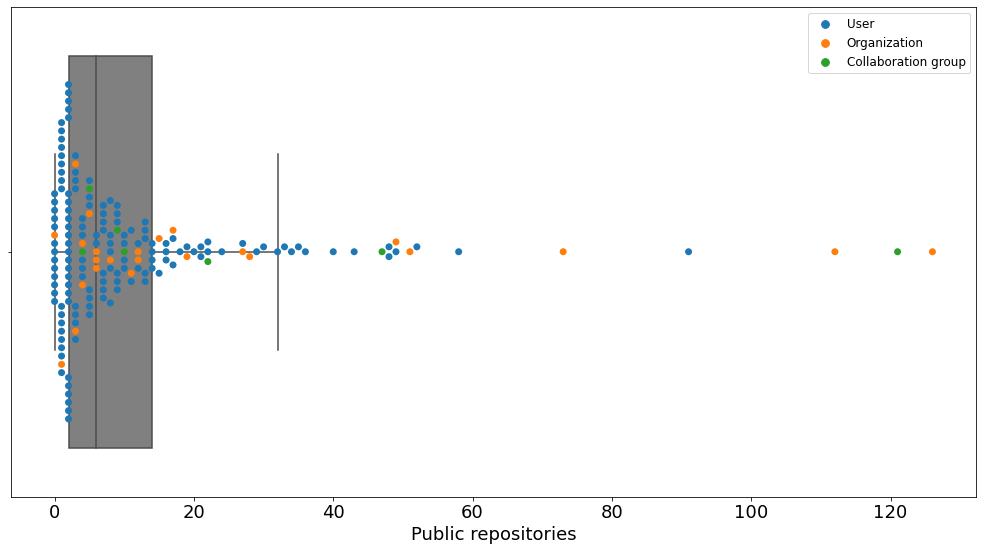

In [8]:
# create a boxplot with swarm
sns.boxplot(x='public_repos', data=df_annotated_users, color=".5", showfliers=False)
s = sns.swarmplot(x='public_repos', y=[""]*len(df_annotated_users), hue="employee_type", data=df_annotated_users, size=7, dodge=False)
s.set_xlabel("Public repositories")

plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'user_public_repos_usertype.png'))

### User statistics

In [9]:
# 25th Percentile
def q25(x):
    return x.quantile(0.25)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

In [10]:
stats_users = df_annotated_users[["public_repos",
                                  "followers",
                                  "following"]].agg(["min", 
                                                     q25, 
                                                     "mean", 
                                                     "median", 
                                                     q75, 
                                                     "max",
                                                     "skew",
                                                     "kurt"])
index_names = ['Minimum', '25th percentile', 'Mean', 'Median', '75th percentile', 'Maximum', 'Skewness', 'Kurtosis']
stats_users.index = index_names
stats_users.columns = ["Public repositories","Followers","Following"]
stats_users = stats_users.round(2)
print(stats_users)
stats_users.to_latex(Path(fp_tables, "stats_users.tex"),
                     column_format = "lccc",
                     label = f"tab:stats_users",
                     caption=f"Descriptive statistics of numeric variables for all users")

                 Public repositories  Followers  Following
Minimum                         0.00       0.00       0.00
25th percentile                 2.00       0.00       0.00
Mean                           13.02      10.32       5.44
Median                          6.00       2.00       1.00
75th percentile                14.00       9.00       4.00
Maximum                       126.00     210.00     103.00
Skewness                        3.31       5.16       4.32
Kurtosis                       13.19      30.98      24.24


### Extra user plots
These are not too interesting and will be added to the appendix

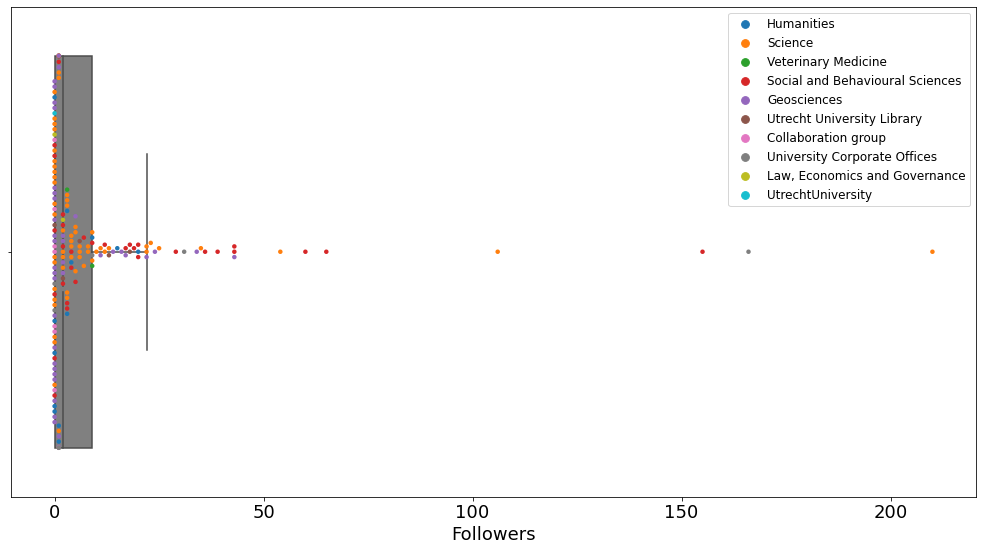

In [11]:
plt.rcParams['figure.figsize'] = [14, 8]
ax = sns.boxplot(x='followers', data=df_annotated_users, color=".5", showfliers=False)
ax = sns.swarmplot(x='followers', y=[""]*len(df_annotated_users), 
                   hue="faculty", data=df_annotated_users, size=4.5)
plt.legend(fontsize=12)
ax.set_xlabel("Followers")
plt.tight_layout()
plt.savefig(Path(fp_figs_extra, f'user_followers.png'))
# df_annotated_users[['user_id', 'followers']].sort_values('followers', ascending=False).head(10)

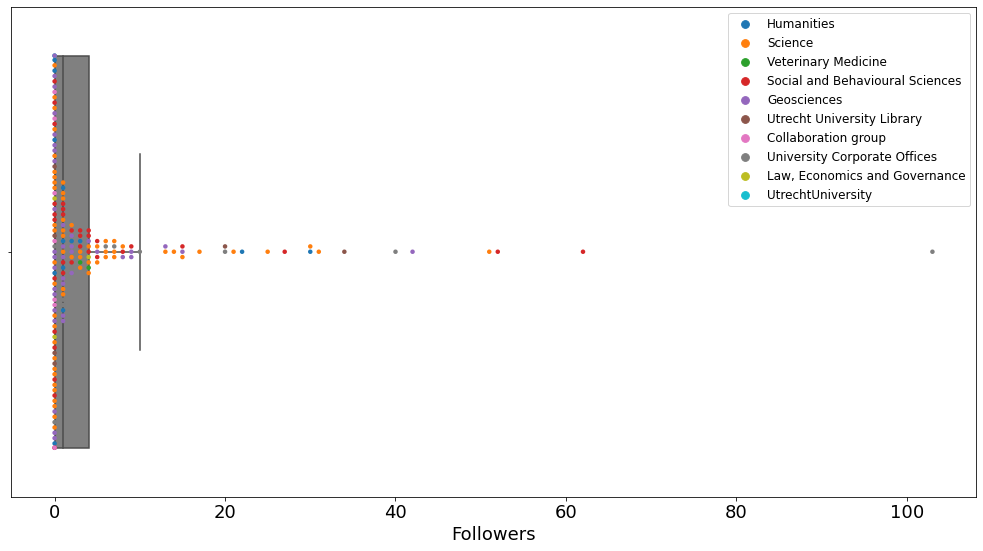

In [12]:
plt.rcParams['figure.figsize'] = [14, 8]
ax = sns.boxplot(x='following', data=df_annotated_users, color=".5", showfliers=False)
ax = sns.swarmplot(x='following', y=[""]*len(df_annotated_users), 
                   hue="faculty", data=df_annotated_users, size=4.5)
plt.legend(fontsize=12)
ax.set_xlabel("Followers")
plt.tight_layout()
plt.savefig(Path(fp_figs_extra, f'user_following.png'))
# df_annotated_users[['user_id', 'following']].sort_values('following', ascending=False).head(10)

## Load and preprocess all other data


- [Top](#Analysis-notebook-for-the-thesis)
- [User analysis](#Analysis-of-user-collection)
- [Load and preprocess data](#Load-and-preprocess-all-data)
- [Repository analysis](#Analysis-of-repositories)
    - [Correlation analysis - subquestion 2](#Correlation-analysis)
    - [Heatmaps](#Heatmaps)
    - [FAIR variables](#FAIR-variables)
    - [Anova](#ANOVA)
- [FAIR analysis](#Analysis-of-FAIR-and-nested-variables)




### Load and merge data
Load (manually) filtered repositories and variables into notebook.

In [13]:
repos = pd.read_excel(fp_repos)
repos["size"] = repos["size"]/1000  # scale size from kb to mb
repos.head()

C:\Users\beld\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,open_issues,watchers,default_branch,permissions,date,faculty,html_url_clickable,repo_type,Note,Label_date
0,247313888,MDEwOlJlcG9zaXRvcnkyNDczMTM4ODg=,AMWG,AJueling/AMWG,False,AJueling,https://github.com/AJueling/AMWG,CESM's AMWG analysis package for IMAU's simula...,False,https://api.github.com/repos/AJueling/AMWG,...,0,0,master,NaN,2022-07-18,Science,https://github.com/AJueling/AMWG,Rscript,NaN,08.08.2022
1,151547397,MDEwOlJlcG9zaXRvcnkxNTE1NDczOTc=,CESM,AJueling/CESM,False,AJueling,https://github.com/AJueling/CESM,NaN,False,https://api.github.com/repos/AJueling/CESM,...,0,1,master,NaN,2022-07-18,Science,https://github.com/AJueling/CESM,Rscript,NaN,08.08.2022
2,373423424,MDEwOlJlcG9zaXRvcnkzNzM0MjM0MjQ=,EC-Earth3-data,AJueling/EC-Earth3-data,False,AJueling,https://github.com/AJueling/EC-Earth3-data,intake-esm catalogues of EC-Earth3(P)-(HR) and...,False,https://api.github.com/repos/AJueling/EC-Earth...,...,0,0,main,NaN,2022-07-18,Science,https://github.com/AJueling/EC-Earth3-data,Rscript,NaN,08.08.2022
3,338361752,MDEwOlJlcG9zaXRvcnkzMzgzNjE3NTI=,FW-code,AJueling/FW-code,False,AJueling,https://github.com/AJueling/FW-code,code for doi:10.5194/os-2020-76,False,https://api.github.com/repos/AJueling/FW-code,...,0,0,main,NaN,2022-07-18,Science,https://github.com/AJueling/FW-code,Rscript,NaN,08.08.2022
4,143137715,MDEwOlJlcG9zaXRvcnkxNDMxMzc3MTU=,LEC,AJueling/LEC,False,AJueling,https://github.com/AJueling/LEC,Lorenz energy Cycle analysis of Parallel Ocean...,False,https://api.github.com/repos/AJueling/LEC,...,0,1,master,NaN,2022-07-18,Science,https://github.com/AJueling/LEC,Rscript,NaN,08.08.2022


Using the github API and the Howfairis software, we collected data on the repositories.

Namely, information about commits, contributors, howfairis variables, languages, readme related variables, test paths, topics, and version usage.

In [14]:
commits = pd.read_csv(fp_commits)
contributors = pd.read_csv(fp_contributors)
how_fair_is = pd.read_csv(fp_howfairis)
languages = pd.read_csv(fp_languages)
readme_variables = pd.read_csv(fp_readme_variables)
test_paths = pd.read_csv(fp_test_paths)
topics = pd.read_csv(fp_topics)
versions = pd.read_csv(fp_versions)

test_paths["has_test"] = pd.notna(test_paths["file_location"])
test_paths.drop("file_location",inplace=True, axis=1)

Preprocess data for merging. This removes the data column and renames the URL to be the same as in the repos dataframe.

In [15]:
def preprocess_extra_datasets(df):
    if "html_url_repository" in df.columns:
        df.rename(columns={"html_url_repository": "html_url"},inplace=True)
    if "date" in df.columns:
        df.drop('date', axis=1, inplace=True)
    else:
        print("Did not preprocess. Data is already preprocessed.")

preprocess_extra_datasets(commits)
preprocess_extra_datasets(contributors)
preprocess_extra_datasets(how_fair_is)
preprocess_extra_datasets(languages)
preprocess_extra_datasets(readme_variables)
preprocess_extra_datasets(test_paths)
preprocess_extra_datasets(topics)
preprocess_extra_datasets(versions)

Combine datasets. `Contributors`, `languages` and `topics` are 1:n datasets and can't be simply merged. Instead, we only retrieve the number of contributors, languages and topics per repository.

In [16]:
num_contributors = contributors.iloc[:,0].value_counts()
num_languages = languages["html_url"].value_counts()
num_topics = topics["html_url"].value_counts()

df_num_contributors = pd.DataFrame(np.array([num_contributors.index, num_contributors]).T, 
                                   columns=["html_url", "contributors_count"])
df_num_languages = pd.DataFrame(np.array([num_languages.index, num_languages]).T, 
                                   columns=["html_url", "languages_count"])
df_num_topics = pd.DataFrame(np.array([num_topics.index, num_topics]).T, 
                                   columns=["html_url", "topics_count"])

Merge repos

In [17]:
if repos.shape[1] <= 85:
    repos = pd.merge(repos, commits, how="left", on="html_url")
    repos = pd.merge(repos, how_fair_is, how="left", on="html_url")
    repos = pd.merge(repos, readme_variables, how="left", on="html_url")
    repos = pd.merge(repos, test_paths, how="left", on="html_url")
    repos = pd.merge(repos, versions, how="left", on="html_url")

    repos = pd.merge(repos, df_num_contributors, how="left", on="html_url")
    repos = pd.merge(repos, df_num_languages, how="left", on="html_url")
    repos = pd.merge(repos, df_num_topics, how="left", on="html_url")
    print("Merged repos.")

else:
    print("Repos are already merged. If not, reload data and execute again.")
repos.head()

Merged repos.


,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,howfairis_citation,howfairis_checklist,has_install_instruction,has_usage_examples,has_contrib_guidelines,has_test,version_identifiable,contributors_count,languages_count,topics_count
0,247313888,MDEwOlJlcG9zaXRvcnkyNDczMTM4ODg=,AMWG,AJueling/AMWG,False,AJueling,https://github.com/AJueling/AMWG,CESM's AMWG analysis package for IMAU's simula...,False,https://api.github.com/repos/AJueling/AMWG,...,False,False,False,False,False,NaN,NaN,1,2,NaN
1,151547397,MDEwOlJlcG9zaXRvcnkxNTE1NDczOTc=,CESM,AJueling/CESM,False,AJueling,https://github.com/AJueling/CESM,NaN,False,https://api.github.com/repos/AJueling/CESM,...,False,False,False,False,False,True,NaN,1,3,NaN
2,373423424,MDEwOlJlcG9zaXRvcnkzNzM0MjM0MjQ=,EC-Earth3-data,AJueling/EC-Earth3-data,False,AJueling,https://github.com/AJueling/EC-Earth3-data,intake-esm catalogues of EC-Earth3(P)-(HR) and...,False,https://api.github.com/repos/AJueling/EC-Earth...,...,False,False,False,False,False,NaN,NaN,1,2,NaN
3,338361752,MDEwOlJlcG9zaXRvcnkzMzgzNjE3NTI=,FW-code,AJueling/FW-code,False,AJueling,https://github.com/AJueling/FW-code,code for doi:10.5194/os-2020-76,False,https://api.github.com/repos/AJueling/FW-code,...,True,False,False,False,False,NaN,True,1,2,NaN
4,143137715,MDEwOlJlcG9zaXRvcnkxNDMxMzc3MTU=,LEC,AJueling/LEC,False,AJueling,https://github.com/AJueling/LEC,Lorenz energy Cycle analysis of Parallel Ocean...,False,https://api.github.com/repos/AJueling/LEC,...,False,False,False,True,False,NaN,True,1,3,NaN


### Fill missing data

Fill missing FAIR variables with False. Missing counts are filled with 0s. The FAIR score is calculated as the sum of all FAIR variables.

Additionally, life_span is missing for 1 repository that was removed / set to private after repository collection and before variable collection. This is also filled with 0.

In [18]:
howfairis_variables = ["howfairis_repository",
                       "howfairis_license",
                       "howfairis_registry",
                       "howfairis_citation",
                       "howfairis_checklist"]
new_fair_variables = ["vcs_usage", 
#                       "life_span", # life span not considered since it's not boolean
                      "repo_active",
                      "has_install_instruction",
                      "has_usage_examples",
                      "has_contrib_guidelines",
                      "has_test",
                      "version_identifiable"]
all_boolean_variables = howfairis_variables + new_fair_variables

numeric_variables = ["stargazers_count",
                     "open_issues",
                     "forks",
                     "size",
                     "contributors_count",
                     "languages_count",
                     "topics_count",
                     "life_span"]

# Fill missing values of booleans with False
repos.fillna(dict.fromkeys(all_boolean_variables, False),inplace=True)
repos["contributors_count"].fillna(1,inplace=True) # at least one contributor is needed
repos["topics_count"].fillna(0,inplace=True) 
repos["languages_count"].fillna(0,inplace=True) 
repos["life_span"].fillna(0,inplace=True) 
repos["fair_score"] = repos[all_boolean_variables].sum(axis=1)

Convert FAIR booleans to integers

In [19]:
repos[all_boolean_variables] = repos[all_boolean_variables].astype(int)
repos[all_boolean_variables].head(5)

,howfairis_repository,howfairis_license,howfairis_registry,howfairis_citation,howfairis_checklist,vcs_usage,repo_active,has_install_instruction,has_usage_examples,has_contrib_guidelines,has_test,version_identifiable
0,1,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,1,0
2,1,1,0,0,0,0,1,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,0,1
4,1,1,0,0,0,0,0,0,1,0,0,1


Create additional dataframes filtered by research-relation. Also, add column for classification.

In [20]:
rs = ["RS", "Rscript", "RSWIP"]
non_rs = ["Empty", "Non-RS", "Rdata", "Workshop", "Docs", "Template", "Student work", "OtherRS", "Irrelevant"]
repos["is_rs"] = repos['repo_type'].isin(rs)

rs_repos = repos.loc[repos['repo_type'].isin(rs)]
non_rs_repos = repos.loc[~repos['repo_type'].isin(rs)]


print(f"Number of repositories considered research software: {len(rs_repos.index)}")
print(f"Number of repositories considered non-research software: {len(non_rs_repos.index)}")

Number of repositories considered research software: 823
Number of repositories considered non-research software: 698


## Descriptive statistics and heatmaps


- [Top](#Analysis-notebook-for-the-thesis)
- [User analysis](#Analysis-of-user-collection)
- [Load and preprocess data](#Load-and-preprocess-all-data)
- [Repository analysis](#Analysis-of-repositories)
    - [Correlation analysis - subquestion 2](#Correlation-analysis)
    - [Heatmaps](#Heatmaps)
    - [FAIR variables](#FAIR-variables)
    - [Anova](#ANOVA)
- [FAIR analysis](#Analysis-of-FAIR-and-nested-variables)

Constants for further plotting

In [21]:
cmap_color = "#429f8c"
cmap = sns.light_palette(cmap_color, as_cmap=True)

fill_value = None
xlabel= None
ylabel= None
plt.rcParams.update({'font.size': 16})

### Count of repositories in each faculty and repository type

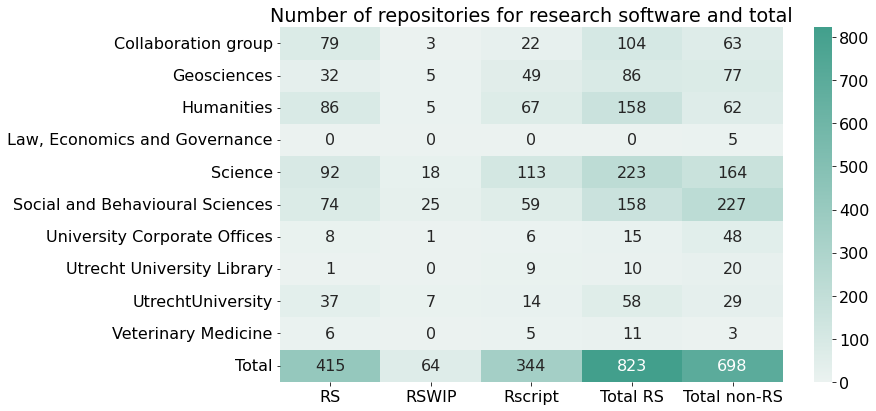

In [22]:
plt.rcParams['figure.figsize'] = [13, 6]
matrix_count = rs_repos.pivot_table(index="faculty", 
                                 columns="repo_type", 
                                 values="size", 
                                 aggfunc=len)
matrix_count_non_rs = non_rs_repos.pivot_table(index="faculty", 
                                             values="size", 
                                             aggfunc=len)

matrix_count_non_rs.rename(columns={"size": "Total non-RS"},inplace=True)
matrix_count["Total RS"] = matrix_count.sum(axis=1)

matrix_total = matrix_count_non_rs.join(matrix_count)
matrix_total.fillna(0,inplace=True)
matrix_total = matrix_total[["RS","RSWIP","Rscript","Total RS","Total non-RS"]]
matrix_total.loc["Total"] = matrix_total.sum(axis=0)

s = sns.heatmap(matrix_total, 
                annot=True, 
                cmap=cmap,
                fmt='g')
s.set(title="Number of repositories for research software and total", xlabel=xlabel, ylabel=ylabel)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_repo_count.png'))

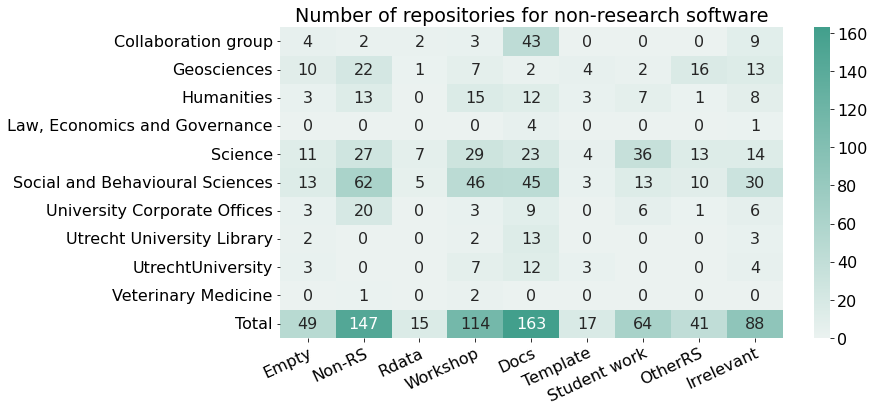

In [23]:
plt.rcParams['figure.figsize'] = [13, 6]
matrix_count_non_rs = non_rs_repos.pivot_table(index="faculty", 
                                          columns="repo_type", 
                                          values="size", 
                                          aggfunc=len)
matrix_count = rs_repos.pivot_table(index="faculty", 
                                                     values="size", 
                                                     aggfunc=len)

matrix_count.rename(columns={"size": "Total RS"},inplace=True)
matrix_count_non_rs["Total non-RS"] = matrix_count_non_rs.sum(axis=1)

matrix_total = matrix_count_non_rs.join(matrix_count, how="left")
matrix_total.fillna(0,inplace=True)

matrix_total = matrix_total[non_rs]

# matrix_total = matrix_total[non_rs + ["Total non-RS", "Total RS"]]
matrix_total.loc["Total"] = matrix_total.sum(axis=0)

s = sns.heatmap(matrix_total, 
                annot=True, 
                cmap=cmap,
                fmt='g')
s.set(title="Number of repositories for non-research software", xlabel=xlabel, ylabel=ylabel)
s.set_xticklabels(s.get_xticklabels(),rotation = 25, ha="right", rotation_mode='anchor')
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_repo_count_non_rs.png'))

#### Further processing of data
Since we see here that some faculty groups are diminishingly small, we group the support-related groups together (University Corporate Offices, University Library, UtrechtUniversity) and exclude Veterinary Medicine and Law, Economics and Governance from further analysis.

In [24]:
# Remove veterinary medicine and law, economics and governance faculties
repos_final = repos[~repos["faculty"].isin(["Veterinary Medicine", 
                                            "Law, Economics and Governance",
                                            "Collaboration group"])]
# Group together support departments
repos_final.loc[:,"faculty"] = repos_final.loc[:,"faculty"].replace(dict.fromkeys(["UtrechtUniversity",
                                                                                   "University Corporate Offices",
                                                                                   "Utrecht University Library"], 
                                                                                  "Support departments"))
repos_final.loc[:,"faculty"] = repos_final.loc[:,"faculty"].replace("Social and Behavioural Sciences","Social Sciences")
faculties_final = ["Geosciences", "Humanities","Science","Social Sciences","Support departments"]

rs_repos_final = repos_final.loc[repos_final['repo_type'].isin(rs)]
non_rs_repos_final = repos_final.loc[~repos_final['repo_type'].isin(rs)]


repos_final["faculty"].value_counts()

C:\Users\beld\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Science                387
Social Sciences        385
Humanities             220
Support departments    180
Geosciences            163
Name: faculty, dtype: int64

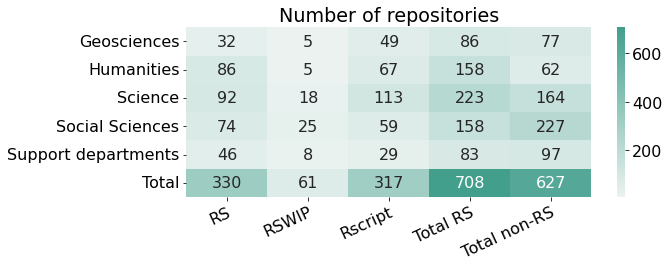

In [25]:
plt.rcParams['figure.figsize'] = [10, 4]
matrix_count = rs_repos_final.pivot_table(index="faculty", 
                                          columns="repo_type", 
                                          values="size", 
                                          aggfunc=len)
matrix_count_non_rs = non_rs_repos_final.pivot_table(index="faculty", 
                                                     values="size", 
                                                     aggfunc=len)

matrix_count_non_rs.rename(columns={"size": "Total non-RS"},inplace=True)
matrix_count["Total RS"] = matrix_count.sum(axis=1)

matrix_total = matrix_count_non_rs.join(matrix_count)
matrix_total.fillna(0,inplace=True)
matrix_total = matrix_total[["RS","RSWIP","Rscript","Total RS","Total non-RS"]]
matrix_total.loc["Total"] = matrix_total.sum(axis=0)

s = sns.heatmap(matrix_total, 
                annot=True, 
                cmap=cmap,
                fmt='g')
s.set(title="Number of repositories", xlabel=xlabel, ylabel=ylabel)
s.set_xticklabels(s.get_xticklabels(),rotation = 25, ha="right", rotation_mode='anchor')
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_repo_count_final.png'))

### FAIR variables Jaccard similarity

In [26]:
print(f"Howfairis length: {len(how_fair_is)}")
print(f"commits length: {len(commits)}")
print(f"readme_variables length: {len(readme_variables)}")
print(f"test_paths length: {len(test_paths)}")
print(f"versions length: {len(versions)}")
versions["version_identifiable"].value_counts()

Howfairis length: 1517
commits length: 1502
readme_variables length: 1317
test_paths length: 338
versions length: 336


True     268
False     68
Name: version_identifiable, dtype: int64

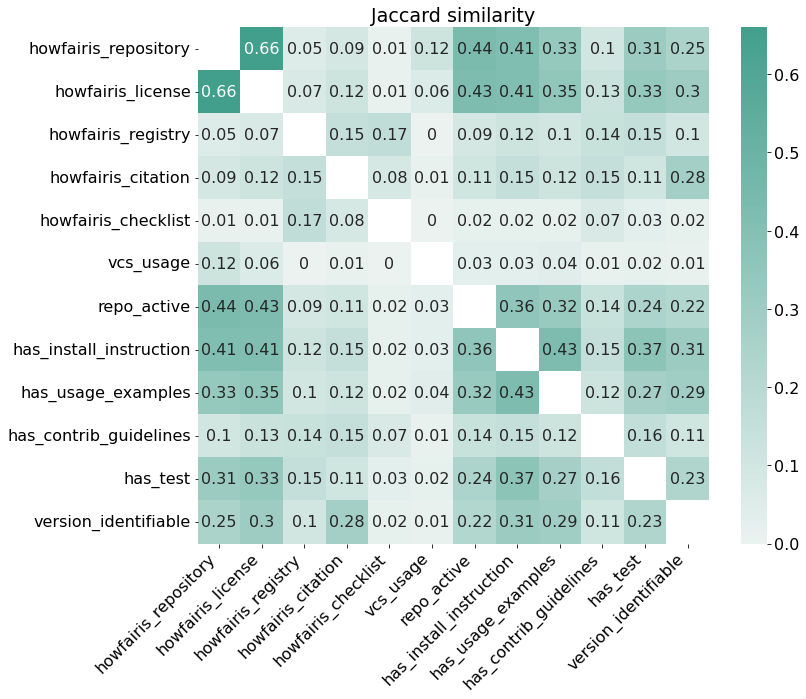

In [27]:
plt.rcParams['figure.figsize'] = [12, 10]

matrix_size = len(all_boolean_variables)
distances = np.zeros(shape=(matrix_size,matrix_size))
for i in range(matrix_size-1): 
    for j in range(i+1, matrix_size):
        distances[i][j] = round(distance.jaccard(rs_repos_final[all_boolean_variables[i]],
                                                 rs_repos_final[all_boolean_variables[j]]),2)

        
i_lower = np.tril_indices(matrix_size, -1)
distances[i_lower] = distances.T[i_lower]  # make the matrix symmetric
        
distances[distances == 0] = np.nan # remove zeros from plot
similarity = 1-distances # turn distance to similarity
pd_similarity = pd.DataFrame(similarity)
pd_similarity.columns = all_boolean_variables
pd_similarity.index = all_boolean_variables

# pd_similarity.drop("version_identifiable",inplace=True,axis=0)
# pd_similarity.drop("howfairis_repository",inplace=True,axis=1)

s = sns.heatmap(pd_similarity, annot=True, cmap=cmap)
s.set_xticklabels(s.get_xticklabels(),rotation = 45, ha="right")
s.set(title="Jaccard similarity")
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_jaccard_similarity.png'))

### Heatmaps for numeric variables

The heatmaps show averages or total counts over the two dimensions `faculty` and `repository type`.

The function `plot_heatmap` can be used for plotting single heatmaps.
The function `plot_subplot_heatmap` can be used for plotting heatmaps in subplots.

**Variable descriptions**


- `Stargazers` represent the amount of people that have 'starred' a Github project. Starring a project can indicate that a user likes the project. It can also be used to bookmark a project, since starred projects are saved. The amount of stargazers can be used as a metric to measure popularity. 

- An `issue` is way to keep track of the tasks, enhancements and bugs of the project. They can be discussed in a thread by users and developers. Each repository can enable their own issue page. An issue can be open, for example when a new bug is found, or closed, when it is solved. This shows the amount of open issues a repository has.

- A `fork` is a copy of a repository for another user.

- The `size` of a repository in kb. This relies on Git alternates. More details can be found here: https://stackoverflow.com/questions/8646517/how-can-i-see-the-size-of-a-github-repository-before-cloning-it/8679592#8679592 There is no official documentation of size calculation.

- `Contributors` refers to the users that have contributed to a repository via commits and pull requests. The number of contributors gives information on how many people put effort into the repository. Theoretically, it would make sense if a higher amount of contributors implied a more FAIR repository, as topics like contribution guidelines and findability become more relevant.

- `Languages` refers to the used languages in a repository. These can be programming languages, markup languages, shell scripts and more. 

- `Topic` refers to the topics a repository is associated with. These are self-assigned. 

- `Life span` refers to the time between the first and last commit in days. 

- `Watchers` receive notifications about project activity. The number of watchers is equal to that of stargazers as described here: https://github.com/orgs/community/discussions/24795
    - Retrieving the subscriber count is not part of the used API request to retrieve repositories: https://docs.github.com/en/rest/repos/repos#list-repositories-for-a-user
    - It would be necessary to retrieve each repository individually via this request: https://docs.github.com/en/rest/repos/repos#get-a-repository
    - Therefore, watchers are not part of the analysis.

In [28]:
def plot_heatmap(repos, value, aggfunc=np.mean, fill_value=None, xlabel=None, ylabel=None, title=None):
    plt.rcParams['figure.figsize'] = [10, 4]
    matrix = repos.pivot_table(index="faculty", 
                              columns="repo_type", 
                              values=value, 
                              aggfunc=aggfunc,
                              fill_value=fill_value)
    matrix_total = repos.pivot_table(index="faculty", 
                                        values=value,              
                                        aggfunc=aggfunc,
                                        fill_value=fill_value)

    matrix["Total"] = matrix_total[value]
    matrix = matrix.round(2)

    s = sns.heatmap(matrix, 
                    annot=True, 
                    cmap=cmap,
                    fmt='g')

    s.set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.tight_layout()
    plt.savefig(Path(fp_figs, f'heatmap_{value}.png'))
    

def plot_subplot_heatmap(ax, repos, value, aggfunc=np.mean, fill_value=None, 
                         xlabel=None, ylabel=None, title=None, avg_row=True):
    matrix = repos.pivot_table(index="faculty", 
                              columns="repo_type", 
                              values=value, 
                              aggfunc=aggfunc,
                              fill_value=fill_value)
    matrix_total = repos.pivot_table(index="faculty", 
                                        values=value,              
                                        aggfunc=aggfunc,
                                        fill_value=fill_value)

    matrix["Total"] = matrix_total[value]
    if avg_row:
        matrix.loc["All"] = matrix.loc[faculties_final].mean(axis=0)
    matrix = matrix.round(2)
    matrix.rename(index={"Support departments": "Supp. dept."},
                  inplace=True)

    s = sns.heatmap(matrix, 
                    annot=True, 
                    cmap=cmap,
                    ax=ax_plot,
                    fmt='g')

    s.set(title=title, xlabel=xlabel, ylabel=ylabel)

In [29]:
# Example call for single heatmap

# value = "stargazers_count"
# aggfunc = np.mean
# title = "Average stargazers per repository type"

# plot_heatmap(repos=rs_repos_final, value=value, aggfunc=aggfunc, title=title)

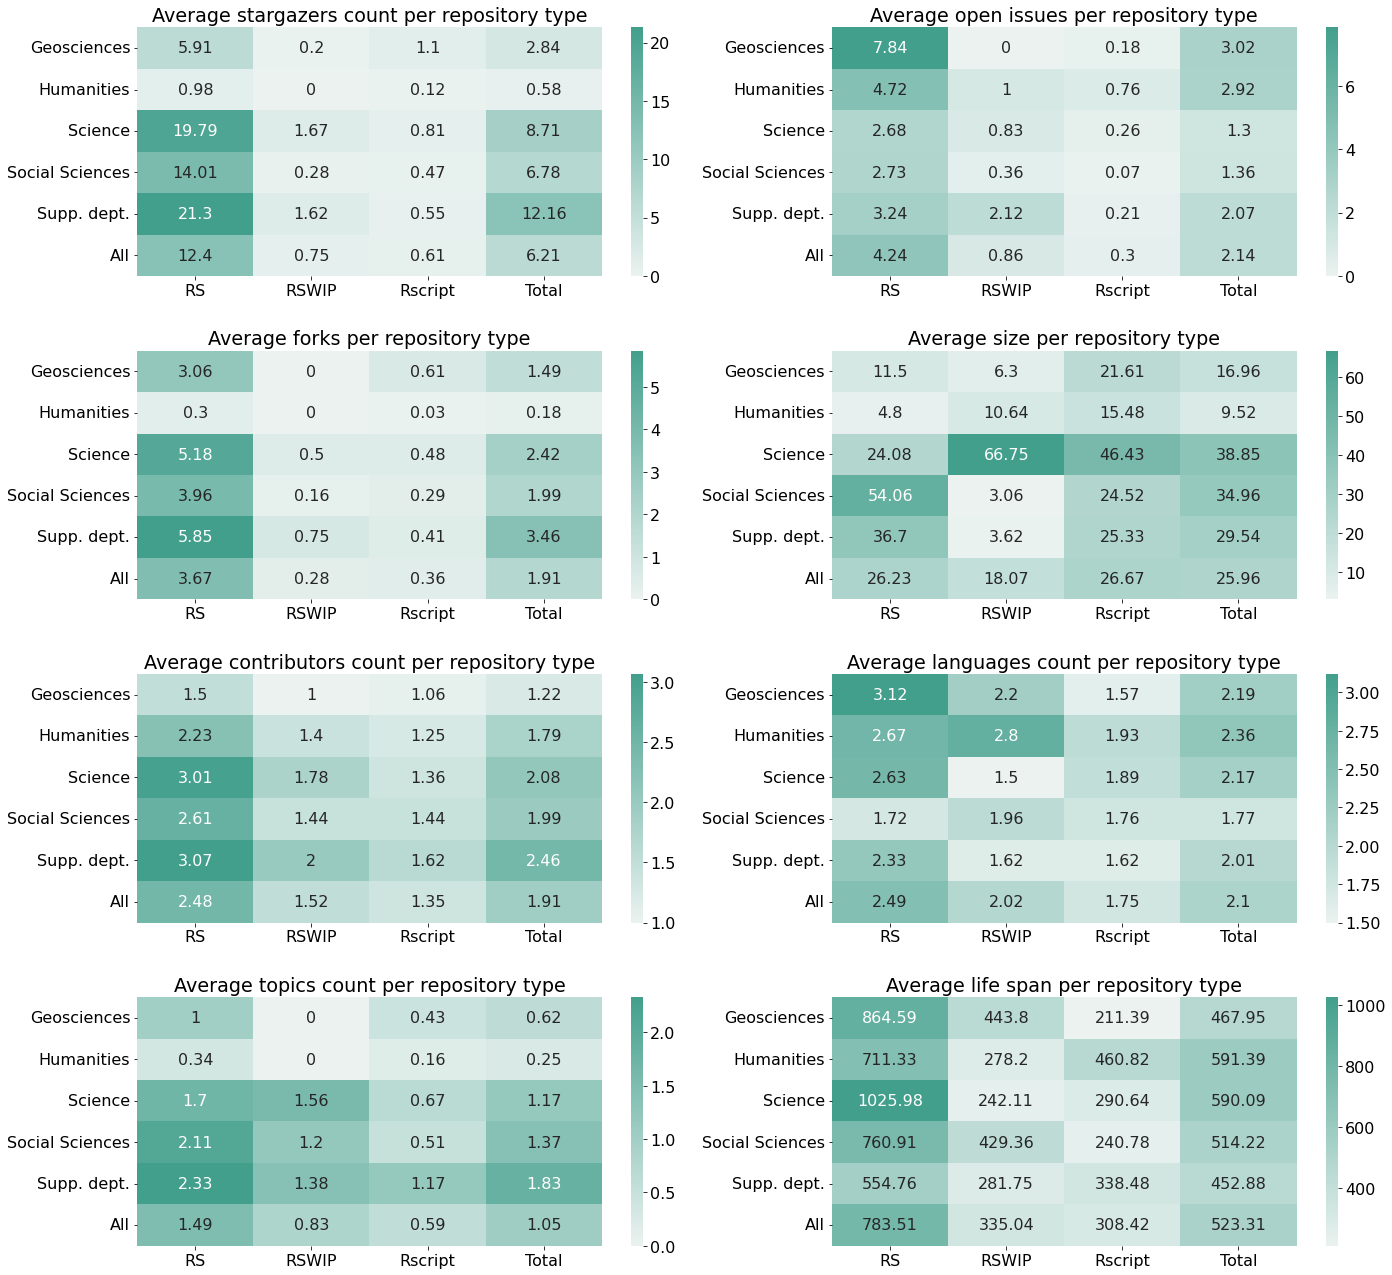

In [30]:
plt.rcParams['figure.figsize'] = [20, 18]
fig, ax = plt.subplots(4, 2)

var_plot_counter = 0
aggfunc = np.mean

for ax_row in ax:
    for ax_plot in ax_row:
        value = numeric_variables[var_plot_counter]
        title = f"Average {value.replace('_', ' ')} per repository type"
        plot_subplot_heatmap(ax_plot, repos=rs_repos_final, value=value, aggfunc=aggfunc, title=title, avg_row=True)
        var_plot_counter += 1
        

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(Path(fp_figs, f'heatmap_numeric_variables.png'))

### FAIR variables

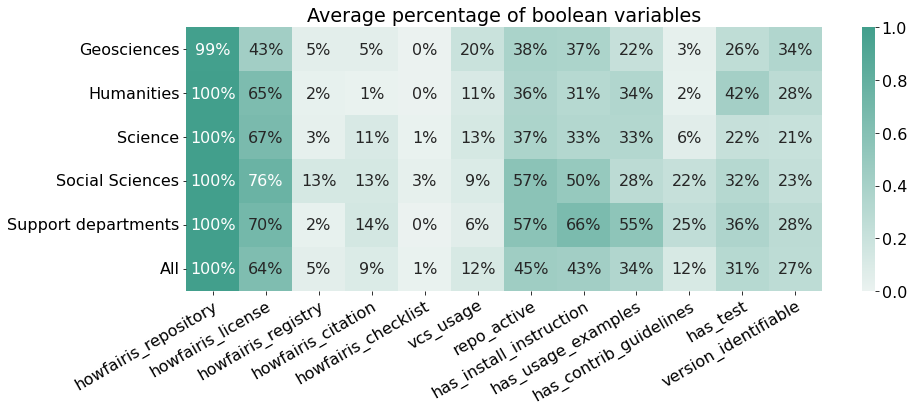

In [31]:
plt.rcParams['figure.figsize'] = [14, 6]
value = all_boolean_variables
aggfunc = np.mean
title = "Average percentage of boolean variables"

matrix = rs_repos_final.pivot_table(index="faculty", 
#                           columns="repo_type", 
                           values=all_boolean_variables, 
                           aggfunc=aggfunc,
#                            sort=False,
                           fill_value=fill_value)

matrix.loc["All"] = matrix.loc[faculties_final].mean(axis=0)
matrix = matrix.round(2)
matrix = matrix[all_boolean_variables]

s = sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt=".0%")

s.set_xticklabels(s.get_xticklabels(),rotation = 30, ha="right", rotation_mode='anchor')
s.set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_fair_booleans.png'))

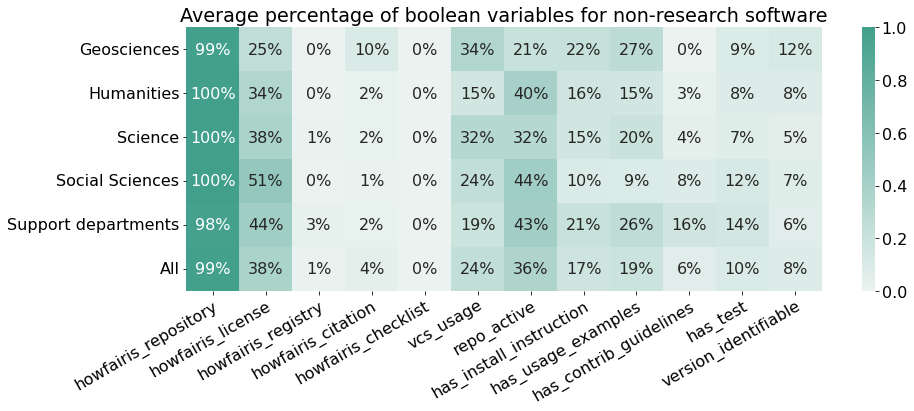

In [32]:
plt.rcParams['figure.figsize'] = [14, 6]
value = all_boolean_variables
aggfunc = np.mean
title = "Average percentage of boolean variables for non-research software"

matrix = non_rs_repos_final.pivot_table(index="faculty", 
#                           columns="repo_type", 
                           values=all_boolean_variables, 
                           aggfunc=aggfunc,
#                            sort=False,
                           fill_value=fill_value)

matrix.loc["All"] = matrix.loc[faculties_final].mean(axis=0)
matrix = matrix.round(2)
matrix = matrix[all_boolean_variables]

s = sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt=".0%")

s.set_xticklabels(s.get_xticklabels(),rotation = 30, ha="right", rotation_mode='anchor')
s.set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_fair_booleans_non_rs.png'))

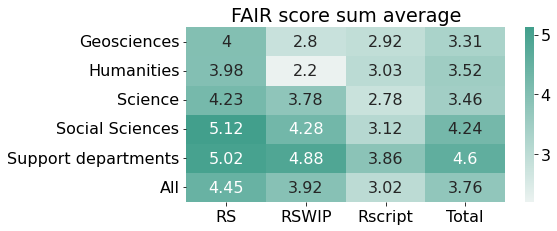

In [33]:
plt.rcParams['figure.figsize'] = [8.5, 3.5]
value = "fair_score"
aggfunc = np.mean
title = "FAIR score sum average"

matrix = rs_repos_final.pivot_table(index="faculty", 
                          columns="repo_type", 
                           values=value, 
                           aggfunc=aggfunc,
                           fill_value=fill_value)

sum_by_repo_type = rs_repos_final.pivot_table(columns="repo_type", 
                           values=value, 
                           aggfunc=aggfunc,
                           fill_value=fill_value)
sum_by_repo_type.rename(index={"fair_score": "All"}, inplace=True)
matrix = pd.concat([matrix, sum_by_repo_type], axis=0)


matrix_total = rs_repos_final.pivot_table(index="faculty", 
                                          values=value, 
                                          aggfunc=aggfunc,
                                          fill_value=fill_value)
matrix_total.loc["All"] = rs_repos_final["fair_score"].mean()

matrix["Total"] = matrix_total.sum(axis=1)
matrix = matrix.round(2)
matrix


s = sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt='g')

s.set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_fair_score.png'))

### Sofware licenses 

A license is important because it shows that people have permission to use and modify your code. The plots below show the licenses used in the collection. 


In [34]:
# short names for licenses
licenses_abbr = {
    'MIT License': 'MIT',
    'GNU General Public License v3.0': 'GPLv3',
    'Other': 'Other',
    'Apache License 2.0': 'Apache 2.0',
    'GNU General Public License v2.0': 'GPLv2',
    'BSD 3-Clause "New" or "Revised" License': 'BSD 3-Clause',
    'Creative Commons Attribution 4.0 International': 'CC-BY',
    'Creative Commons Zero v1.0 Universal': 'CC0',
    'GNU Lesser General Public License v3.0': 'LGPLv3',
    'The Unlicense': 'Unlicense',
    'GNU Affero General Public License v3.0': 'AGPPLv3',
    'BSD 2-Clause "Simplified" License': 'BSD 2-Clause',
    'Mozilla Public License 2.0': 'MPL 2.0',
    'GNU Lesser General Public License v2.1': 'LGPLv2.1',
    'Creative Commons Attribution Share Alike 4.0 International': 'CC-BY-SA',
    'ISC License': 'ISC'
    
}


rs_repos_final.loc[:,"license_short"] = rs_repos_final.loc[:,"license"].replace(licenses_abbr)
rs_repos_final["license_short"].value_counts()

C:\Users\beld\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


MIT             143
GPLv3           104
Other            57
Apache 2.0       47
GPLv2            46
BSD 3-Clause     25
CC-BY            13
AGPPLv3          12
LGPLv3            6
CC0               5
Unlicense         3
LGPLv2.1          3
BSD 2-Clause      2
ISC               1
Name: license_short, dtype: int64

Highest occuring license per faculty per repository type

In [35]:
matrix = rs_repos_final.pivot_table(index="faculty", 
                          columns="repo_type", 
                           values="license_short",
                           aggfunc=pd.Series.mode)
#                            fill_value=fill_value)

matrix_stringified = matrix.applymap(lambda row: row if isinstance(row, str) else ', '.join(row))

matrix_stringified.to_latex(Path(fp_tables, "stats_highest_license.tex"),
                            column_format = "lccc",
                            label = f"tab:highest_license",
                            caption=f"Highest occurring license")
matrix_stringified

repo_type,RS,RSWIP,Rscript
faculty,,,
Geosciences,GPLv3,MIT,"GPLv3, MIT"
Humanities,"GPLv2, MIT",Other,GPLv2
Science,Apache 2.0,MIT,MIT
Social Sciences,Other,GPLv3,"GPLv3, MIT"
Support departments,MIT,GPLv3,MIT


In [36]:
licenses_per_faculty = []
faculties = []
for faculty in rs_repos_final["faculty"].unique():
    faculties.append(faculty)
    licenses_per_faculty.append(rs_repos_final.loc[(rs_repos_final["faculty"]==faculty)]\
                                ["license_short"].value_counts(dropna=False))


license_count = pd.DataFrame(licenses_per_faculty)
license_count.index = faculties
license_count = license_count.reindex(faculties_final)
license_count.fillna(0, inplace=True)
license_count.rename(columns={np.nan: "No license"},inplace=True)


license_count.loc['Total']= license_count.sum()
license_count.sort_values(license_count.last_valid_index(), axis=1, ascending=False, inplace=True)

license_count

license_count_percentage = license_count.div(license_count.sum(axis=1), axis=0)
license_count_percentage

,No license,MIT,GPLv3,Other,Apache 2.0,GPLv2,BSD 3-Clause,CC-BY,AGPPLv3,LGPLv3,CC0,Unlicense,LGPLv2.1,BSD 2-Clause,ISC
Geosciences,0.569767,0.197674,0.186047,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.011628,0.011628,0.000000,0.000000,0.000000,0.000000
Humanities,0.348101,0.107595,0.101266,0.056962,0.006329,0.253165,0.088608,0.000000,0.000000,0.000000,0.000000,0.012658,0.018987,0.000000,0.006329
Science,0.331839,0.251121,0.103139,0.058296,0.161435,0.022422,0.031390,0.000000,0.013453,0.004484,0.013453,0.004484,0.000000,0.004484,0.000000
Social Sciences,0.240506,0.170886,0.227848,0.170886,0.044304,0.006329,0.012658,0.082278,0.037975,0.006329,0.000000,0.000000,0.000000,0.000000,0.000000
Support departments,0.301205,0.313253,0.156627,0.072289,0.036145,0.000000,0.024096,0.000000,0.036145,0.036145,0.012048,0.000000,0.000000,0.012048,0.000000
Total,0.340395,0.201977,0.146893,0.080508,0.066384,0.064972,0.035311,0.018362,0.016949,0.008475,0.007062,0.004237,0.004237,0.002825,0.001412


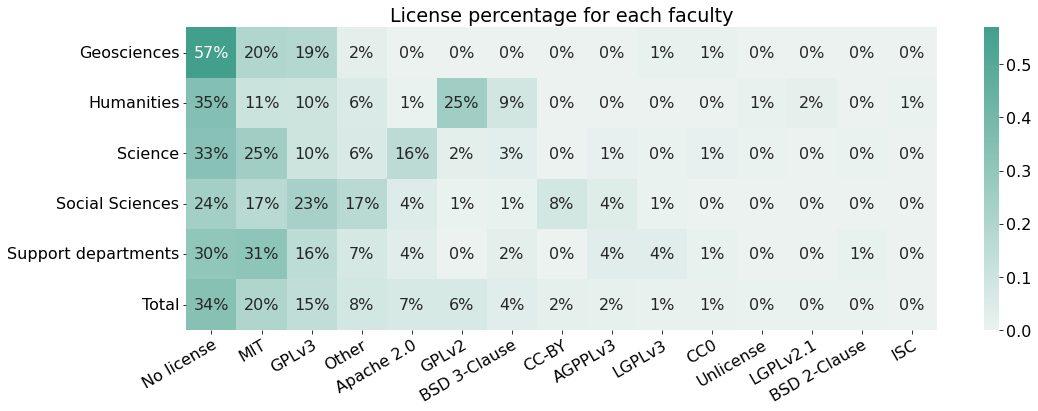

In [37]:
plt.rcParams['figure.figsize'] = [16, 6]

title = "License percentage for each faculty"

s = sns.heatmap(license_count_percentage, 
                annot=True, 
                cmap=cmap,
                fmt='.0%')

s.set(title=title, xlabel=xlabel, ylabel=ylabel)
s.set_xticklabels(s.get_xticklabels(),rotation = 30, ha="right", rotation_mode='anchor')
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_licenses.png'))

Below, the propotion of licenses compared to the total is shown, with their absolute count shown below that. . 

### Languages

The programming language that is used in the repository gives information on the type of project the repository is. data analysis is mostly done in R and Python, though Python is used for other purposes as well. 

**Verbose languages**

Please note that due to the way GitHub calculates the dominant language in a repository, **Jupyter Notebooks** and **HTML** tend to be the top language if used in a repository. The top language is determined by the number of characters, which is usually much larger in Jupyter Notebook files and to a lesser extent HTML files, compared to for example Python scripts.

In [38]:
rs_repos_final["language"].value_counts().head(10)

matrix = rs_repos_final.pivot_table(index="faculty", 
                          columns="repo_type", 
                           values="language",
                           aggfunc=pd.Series.mode)


matrix_stringified = matrix.applymap(lambda row: row if isinstance(row, str) else ', '.join(row))
matrix_stringified.to_latex(Path(fp_tables, "stats_highest_language.tex"),
                            column_format = "lccc",
                            label = f"tab:highest_language",
                            caption=f"Highest occurring language")
matrix_stringified

repo_type,RS,RSWIP,Rscript
faculty,,,
Geosciences,Python,"JavaScript, MATLAB, Python, Shell",MATLAB
Humanities,Python,JavaScript,Shell
Science,Python,Python,Python
Social Sciences,R,R,R
Support departments,Python,R,R


In [39]:
languages_per_faculty = []
faculties = []
for faculty in rs_repos_final["faculty"].unique():
    faculties.append(faculty)
    languages_per_faculty.append(rs_repos_final.loc[(rs_repos_final["faculty"]==faculty)]\
                                ["language"].value_counts(dropna=False))


languages_count = pd.DataFrame(languages_per_faculty)
languages_count.index = faculties
languages_count = languages_count.reindex(faculties_final)
languages_count.fillna(0, inplace=True)
languages_count.rename(columns={np.nan: "No language"},inplace=True)


languages_count.loc['Total']= languages_count.sum()
languages_count.sort_values(languages_count.last_valid_index(), axis=1, ascending=False, inplace=True)

languages_count

,Python,R,Jupyter Notebook,Shell,No language,JavaScript,HTML,MATLAB,Java,Haskell,...,CSS,Prolog,QML,XSLT,Roff,Emacs Lisp,Agda,Coq,ImageJ Macro,SCSS
Geosciences,30.0,14.0,5.0,3.0,10.0,2.0,1.0,14.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Humanities,48.0,3.0,3.0,37.0,9.0,28.0,2.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Science,93.0,11.0,43.0,6.0,7.0,3.0,7.0,4.0,13.0,14.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
Social Sciences,30.0,85.0,3.0,2.0,5.0,0.0,21.0,2.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Support departments,32.0,14.0,8.0,2.0,7.0,4.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Total,233.0,127.0,62.0,50.0,38.0,37.0,34.0,21.0,15.0,14.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [40]:
languages_count.loc["Total"]

languages_count_higher_ten = languages_count.loc[:, languages_count.loc["Total"] >= 10]
languages_count_higher_ten

,Python,R,Jupyter Notebook,Shell,No language,JavaScript,HTML,MATLAB,Java,Haskell,C++
Geosciences,30.0,14.0,5.0,3.0,10.0,2.0,1.0,14.0,0.0,0.0,3.0
Humanities,48.0,3.0,3.0,37.0,9.0,28.0,2.0,0.0,1.0,0.0,2.0
Science,93.0,11.0,43.0,6.0,7.0,3.0,7.0,4.0,13.0,14.0,2.0
Social Sciences,30.0,85.0,3.0,2.0,5.0,0.0,21.0,2.0,1.0,0.0,2.0
Support departments,32.0,14.0,8.0,2.0,7.0,4.0,3.0,1.0,0.0,0.0,3.0
Total,233.0,127.0,62.0,50.0,38.0,37.0,34.0,21.0,15.0,14.0,12.0


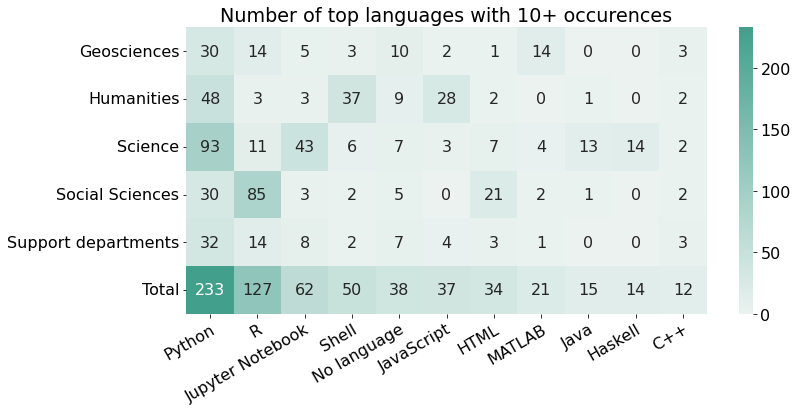

In [41]:
plt.rcParams['figure.figsize'] = [12, 6]

title = "Number of top languages with 10+ occurences"

s = sns.heatmap(languages_count_higher_ten, 
                annot=True, 
                cmap=cmap,
                fmt='g')

s.set(title=title, xlabel=xlabel, ylabel=ylabel)
s.set_xticklabels(s.get_xticklabels(),rotation = 30, ha="right", rotation_mode='anchor')
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_languages_tenplus.png'))

Language occurences

In [42]:
faculties_languages_list = []
faculties = []
percent_threshold = 10
for faculty in rs_repos_final["faculty"].unique():
    faculties.append(faculty)
    faculty_df = rs_repos_final.loc[(rs_repos_final["faculty"]==faculty)]
    languages_faculty = pd.merge(languages, faculty_df["html_url"], on="html_url")
    language_percentage_faculty = []
    for value, language in zip(languages_faculty["language"].value_counts(),
                               languages_faculty["language"].value_counts().keys()):
        percentage = value / len(faculty_df) * 100
#         print("{} is present in {:.2f} % of all repositories in {}". format(language, percentage, faculty))
        language_percentage_faculty.append([language, percentage])
    faculties_languages_list.append(language_percentage_faculty)
    

df_faculty_list = []
for faculty, faculty_list in zip(faculties, faculties_languages_list):
    df_faculty = pd.DataFrame(faculty_list, columns=["language",faculty]).set_index("language")
    df_faculty_list.append(df_faculty)
    
df_language_percentage = pd.concat(df_faculty_list, axis='columns')

# filter out all languages where no faculty has more than 10%
df_language_percentage = df_language_percentage[(df_language_percentage>percent_threshold).any(axis=1)]

df_language_percentage['Total'] = df_language_percentage.sum(axis=1)
df_language_percentage = df_language_percentage.sort_values("Total", ascending=False).T
df_language_percentage.drop("Total",inplace=True,axis=0)
df_language_percentage.fillna(0, inplace=True)
df_language_percentage = df_language_percentage.reindex(faculties_final)

df_language_percentage

language,Python,R,Shell,HTML,JavaScript,Jupyter Notebook,CSS,Batchfile,TeX,MATLAB,Makefile,CMake
Geosciences,50.000000,16.279070,32.558140,8.139535,6.976744,6.976744,4.651163,8.139535,2.325581,17.441860,10.465116,10.465116
Humanities,46.835443,5.063291,31.645570,31.012658,32.278481,3.797468,15.822785,19.620253,3.164557,0.632911,1.265823,1.265823
Science,64.125561,7.623318,21.076233,10.762332,5.829596,23.318386,4.035874,4.484305,5.381166,6.726457,4.932735,0.896861
Social Sciences,25.316456,72.151899,5.696203,20.886076,4.430380,5.696203,5.063291,1.265823,16.455696,1.265823,1.265823,0.000000
Support departments,53.012048,25.301205,26.506024,18.072289,8.433735,15.662651,10.843373,3.614458,0.000000,1.204819,1.204819,4.819277


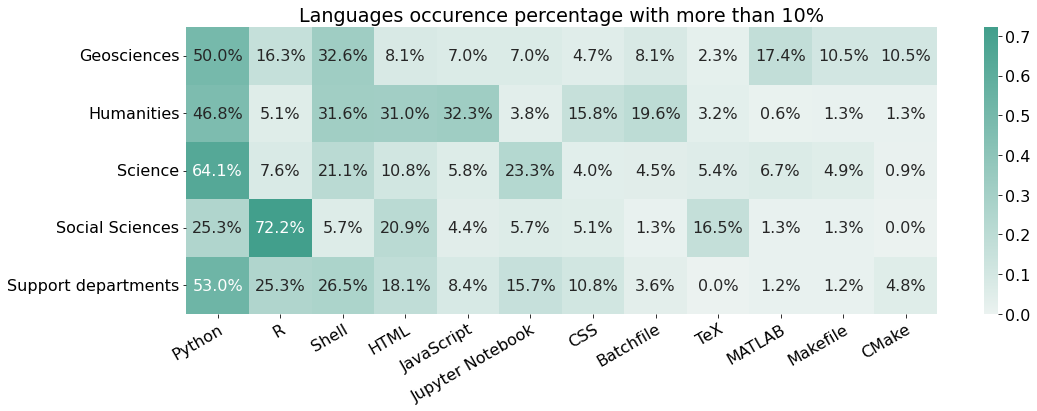

In [43]:
plt.rcParams['figure.figsize'] = [16, 6]

title = "Languages occurence percentage with more than 10%"

s = sns.heatmap(df_language_percentage/100, 
                annot=True, 
                cmap=cmap,
                fmt='.1%')

s.set(title=title, xlabel=xlabel, ylabel=ylabel)
s.set_xticklabels(s.get_xticklabels(),rotation = 30, ha="right", rotation_mode='anchor')
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_languages_percentage.png'))

### Topics

Topics describe the context of the repository. 

In [44]:
print(topics['topic'].value_counts().nlargest(15))

topic_threshold = 6
topics_count = topics["topic"].value_counts()
topics_filter = topics_count.loc[topics_count>=topic_threshold].reset_index()["index"]
topics_filtered = topics[topics["topic"].isin(topics_filter)]
topics_filtered

utrecht-university    48
python                27
asreview              22
r                     18
stan                  15
machine-learning      14
james-server          12
irods                 11
growth-curves         10
research              10
r-package             10
open-science           9
systematic-reviews     8
statistics             8
growth-charts          8
Name: topic, dtype: int64


,html_url,topic
3,https://github.com/amices/dsMice,mice
7,https://github.com/amices/dsMiceClient,mice
9,https://github.com/amices/ggmice,mice
10,https://github.com/amices/ggmice,r
16,https://github.com/amices/mice,mice
...,...,...
1211,https://github.com/UtrechtUniversity/yoda-clie...,yoda
1213,https://github.com/UtrechtUniversity/yoda-exte...,yoda
1221,https://github.com/UUDigitalHumanitieslab/texc...,python
1229,https://github.com/vankesteren/blog,r


In [45]:
faculties_topics_list = []
faculties = []
percent_threshold = 2
for faculty in rs_repos_final["faculty"].unique():
    faculties.append(faculty)
    faculty_df = rs_repos_final.loc[(rs_repos_final["faculty"]==faculty)]
    topics_faculty = pd.merge(topics_filtered, faculty_df["html_url"], on="html_url")
    topics_percentage_faculty = []
    for value, topic in zip(topics_faculty["topic"].value_counts(),
                               topics_faculty["topic"].value_counts().keys()):
        percentage = value / len(faculty_df) * 100
#         print("{} is present in {:.2f} % of all repositories in {}". format(topic, percentage, faculty))
        topics_percentage_faculty.append([topic, percentage])
    faculties_topics_list.append(topics_percentage_faculty)
    
    
df_faculty_list = []
for faculty, faculty_list in zip(faculties, faculties_topics_list):
    df_faculty = pd.DataFrame(faculty_list, columns=["topic",faculty]).set_index("topic")
    df_faculty_list.append(df_faculty)
    
df_topics_percentage = pd.concat(df_faculty_list, axis='columns')
df_topics_percentage
# filter out all languages where no faculty has more than 10%
# df_topics_percentage = df_topics_percentage[(df_topics_percentage>percent_threshold).any(axis=1)]

df_topics_percentage['Total'] = df_topics_percentage.sum(axis=1)
df_topics_percentage = df_topics_percentage.sort_values("Total", ascending=False).T
df_topics_percentage.drop("Total",inplace=True,axis=0)
df_topics_percentage.fillna(0, inplace=True)
df_topics_percentage = df_topics_percentage.reindex(faculties_final)

df_topics_percentage

topic,utrecht-university,irods,python,asreview,yoda,james-server,growth-curves,machine-learning,growth-charts,research,...,fiji-plugin,open-science,open-data,mice,dutch,bioinformatics,imagej-plugins,data-science,r-package,statistics
Geosciences,0.000000,0.000000,1.162791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.162791,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Humanities,0.000000,0.000000,2.531646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.632911,0.000000,0.000000,0.000000,0.000000,0.000000
Science,6.726457,0.000000,3.139013,0.000000,0.000000,0.000000,0.000000,1.345291,0.000000,0.000000,...,3.587444,0.896861,0.896861,0.000000,0.000000,3.139013,2.690583,0.000000,0.000000,0.000000
Social Sciences,3.164557,0.000000,1.898734,10.759494,0.000000,7.594937,6.329114,1.898734,5.063291,1.265823,...,0.000000,0.000000,0.000000,3.164557,2.531646,0.000000,0.000000,1.265823,0.000000,0.632911
Support departments,13.253012,13.253012,2.409639,0.000000,8.433735,0.000000,0.000000,2.409639,0.000000,2.409639,...,0.000000,2.409639,2.409639,0.000000,0.000000,0.000000,0.000000,0.000000,1.204819,0.000000


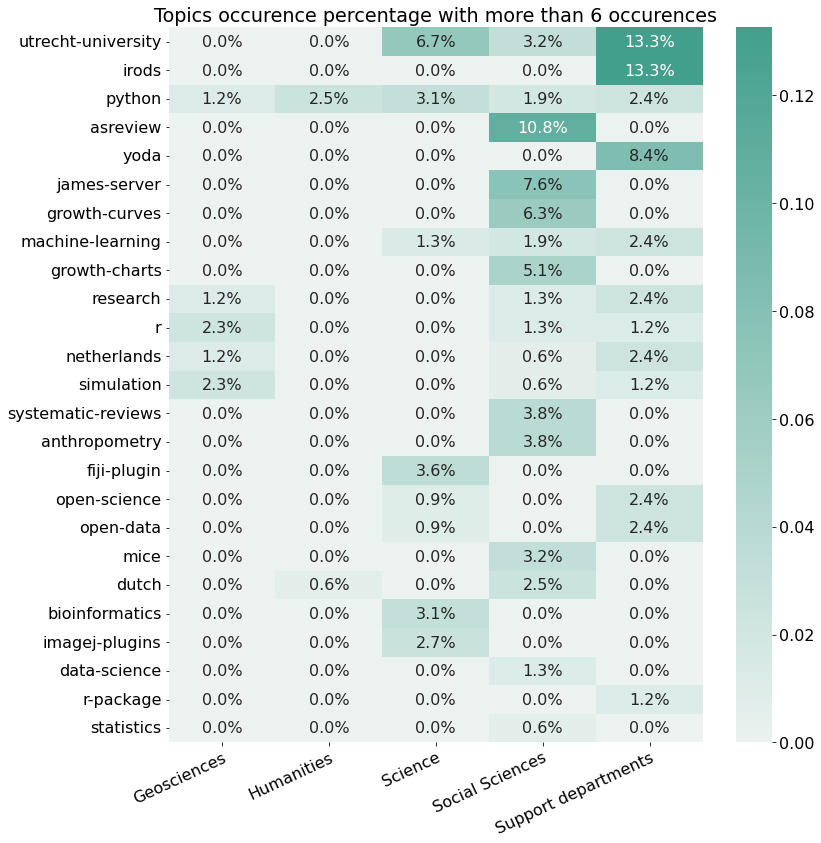

In [46]:
plt.rcParams['figure.figsize'] = [12, 12]

title = f"Topics occurence percentage with more than {topic_threshold} occurences"

s = sns.heatmap(df_topics_percentage.T/100, 
                annot=True, 
                cmap=cmap,
                fmt='.1%')

s.set(title=title, xlabel=xlabel, ylabel=ylabel)
s.set_xticklabels(s.get_xticklabels(),rotation = 25, ha="right", rotation_mode='anchor')
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_topics_percentage.png'))

### Descriptive statistics (table)

In [47]:
# 25th Percentile
def q25(x):
    return x.quantile(0.25)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

statistical_functions = ["min", q25, "mean", "median", q75, "max", "skew", "kurt"]

def export_to_latex(df, faculty, col_names, index_names, print_table=False):
    stats_repos.columns = col_names
    stats_repos.index = index_names
    file_name = faculty.replace(" ", "_")

    stats_repos.to_latex(Path(fp_tables, f"repo_stats_{file_name}.tex"), 
                         column_format = "lcccccccc",
                         label = f"tab:{file_name}",
                         caption=f"Descriptive statistics of numeric variables for {faculty}")
    if print_table:
        print(stats_repos.to_string())
    print(f"Exported tex table {faculty}")

col_names = ["Stargazers", "Issues", "Forks", "Size", "Contributors", "Languages", "Topics", "Life span"]
index_names = ['Minimum', '25th percentile', 'Mean', 'Median', '75th percentile', 'Maximum', 'Skewness', 'Kurtosis']

Table with all faculties

In [48]:
stats_repos = rs_repos_final[numeric_variables].agg(statistical_functions).round(2)
export_to_latex(stats_repos, "all faculties", col_names, index_names)

Exported tex table all faculties


Tables for each faculty

In [49]:
for faculty in rs_repos_final["faculty"].unique():
    stats_repos = rs_repos_final.loc[rs_repos_final["faculty"] == faculty][numeric_variables]\
                                .agg(statistical_functions)\
                                .round(2)
    export_to_latex(stats_repos, faculty, col_names, index_names)


Exported tex table Science
Exported tex table Social Sciences
Exported tex table Geosciences
Exported tex table Humanities
Exported tex table Support departments


### Correlation

Correlation average: 0.30892857142857144


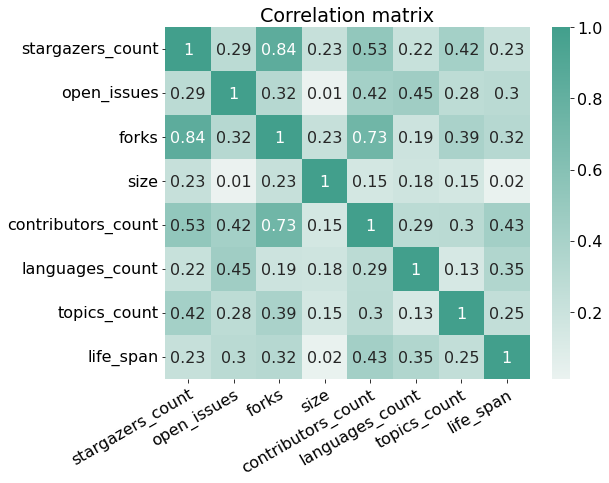

In [50]:
numeric_correlations = rs_repos_final[numeric_variables].corr()


plt.rcParams['figure.figsize'] = [9, 7]
title = "Correlation matrix"

numeric_correlations = numeric_correlations.round(2)


s = sns.heatmap(numeric_correlations, 
                annot=True, 
                cmap=cmap,
                fmt='g')

s.set(title=title, xlabel=xlabel, ylabel=ylabel)
s.set_xticklabels(s.get_xticklabels(),rotation = 30, ha="right", rotation_mode='anchor')
plt.tight_layout()
plt.savefig(Path(fp_figs, f'heatmap_correlation_numeric.png'))

mean_correlation = numeric_correlations.values[np.triu_indices_from(numeric_correlations.values,1)].mean()
print(f"Correlation average: {mean_correlation}")

## Statistical analysis

- [Top](#Analysis-notebook-for-the-thesis)
- [User analysis](#Analysis-of-user-collection)
- [Repository analysis](#Analysis-of-repositories)
    - [Correlation analysis - subquestion 2](#Correlation-analysis)
    - [Heatmaps](#Heatmaps)
    - [FAIR variables](#FAIR-variables)
    - [Anova](#Statistical-analysis)
- [Further plots](#Further-plots)

This part includes all statistical analysis: statistical tests and machine learning classification models

### Histograms

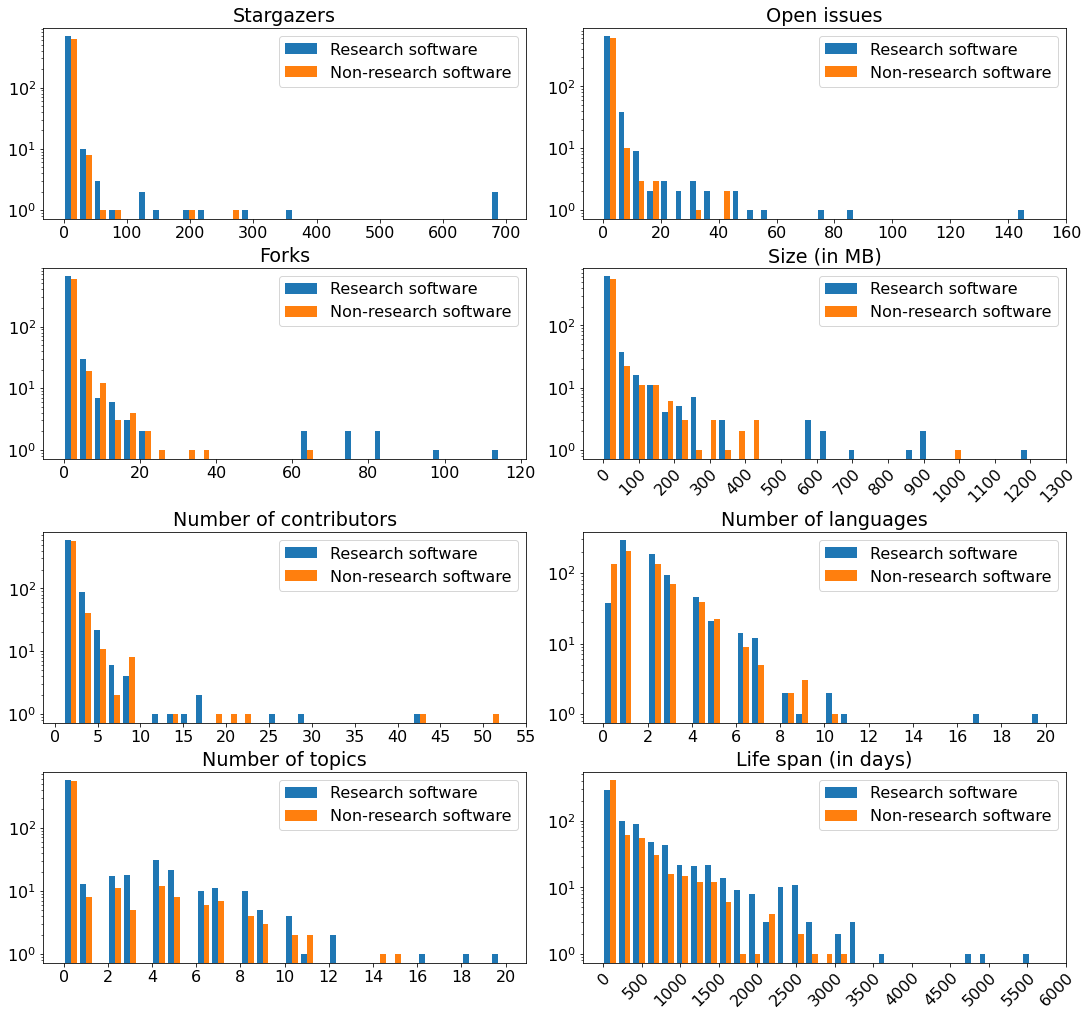

In [51]:
plt.rcParams['figure.figsize'] = [15, 14]
fig, ax = plt.subplots(4, 2, constrained_layout=True)
label_non_rs = ["Research software", "Non-research software"]
rotation=45


plot_var = "stargazers_count"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=100
title="Stargazers"
ax[0,0].hist(cols,bins=30, label=label_non_rs)
ax[0,0].set_yscale("log")
ax[0,0].legend(loc='upper right')
ax[0,0].set_title(title)
ax[0,0].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))
ax[0,0].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))


plot_var = "open_issues"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=20
title="Open issues"
ax[0,1].hist(cols,bins=30, label=label_non_rs)
ax[0,1].set_yscale("log")
ax[0,1].legend(loc='upper right')
ax[0,1].set_title(title)
ax[0,1].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))
ax[0,1].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))

plot_var = "forks"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=20
title="Forks"
ax[1,0].hist(cols,bins=30, label=label_non_rs)
ax[1,0].set_yscale("log")
ax[1,0].legend(loc='upper right')
ax[1,0].set_title(title)
ax[1,0].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))
ax[1,0].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))


plot_var = "size"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=100
title="Size (in MB)"
ax[1,1].hist(cols,bins=30, label=label_non_rs)
ax[1,1].set_yscale("log")
ax[1,1].legend(loc='upper right')
ax[1,1].set_title(title)
ax[1,1].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
ax[1,1].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int), 
                        rotation=rotation, ha="right", rotation_mode='anchor')


plot_var = "contributors_count"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=5
title="Number of contributors"
ax[2,0].hist(cols,bins=30, label=label_non_rs)
ax[2,0].set_yscale("log")
ax[2,0].legend(loc='upper right')
ax[2,0].set_title(title)
ax[2,0].set_xticks(np.arange(0, max(map(max, cols))+xticks, xticks).astype(int))
ax[2,0].set_xticklabels(np.arange(0, max(map(max, cols))+xticks, xticks).astype(int))


plot_var = "languages_count"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=2
title="Number of languages"
ax[2,1].hist(cols,bins=30, label=label_non_rs)
ax[2,1].set_yscale("log")
ax[2,1].legend(loc='upper right')
ax[2,1].set_title(title)
ax[2,1].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
ax[2,1].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))


plot_var = "topics_count"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=2
title="Number of topics"
ax[3,0].hist(cols,bins=30, label=label_non_rs)
ax[3,0].set_yscale("log")
ax[3,0].legend(loc='upper right')
ax[3,0].set_title(title)
ax[3,0].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
ax[3,0].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))


plot_var = "life_span"
cols = [rs_repos_final[plot_var], non_rs_repos_final[plot_var]]
xticks=500
title="Life span (in days)"
ax[3,1].hist(cols,bins=30, label=label_non_rs)
ax[3,1].set_yscale("log")
ax[3,1].legend(loc='upper right')
ax[3,1].set_title(title)
ax[3,1].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
ax[3,1].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int), 
                        rotation=rotation, ha="right", rotation_mode='anchor')

# plt.subplots_adjust(hspace=0.5)
# plt.tight_layout()
plt.savefig(Path(fp_figs, f'stats_histograms.png'))

Same histograms without non-research software

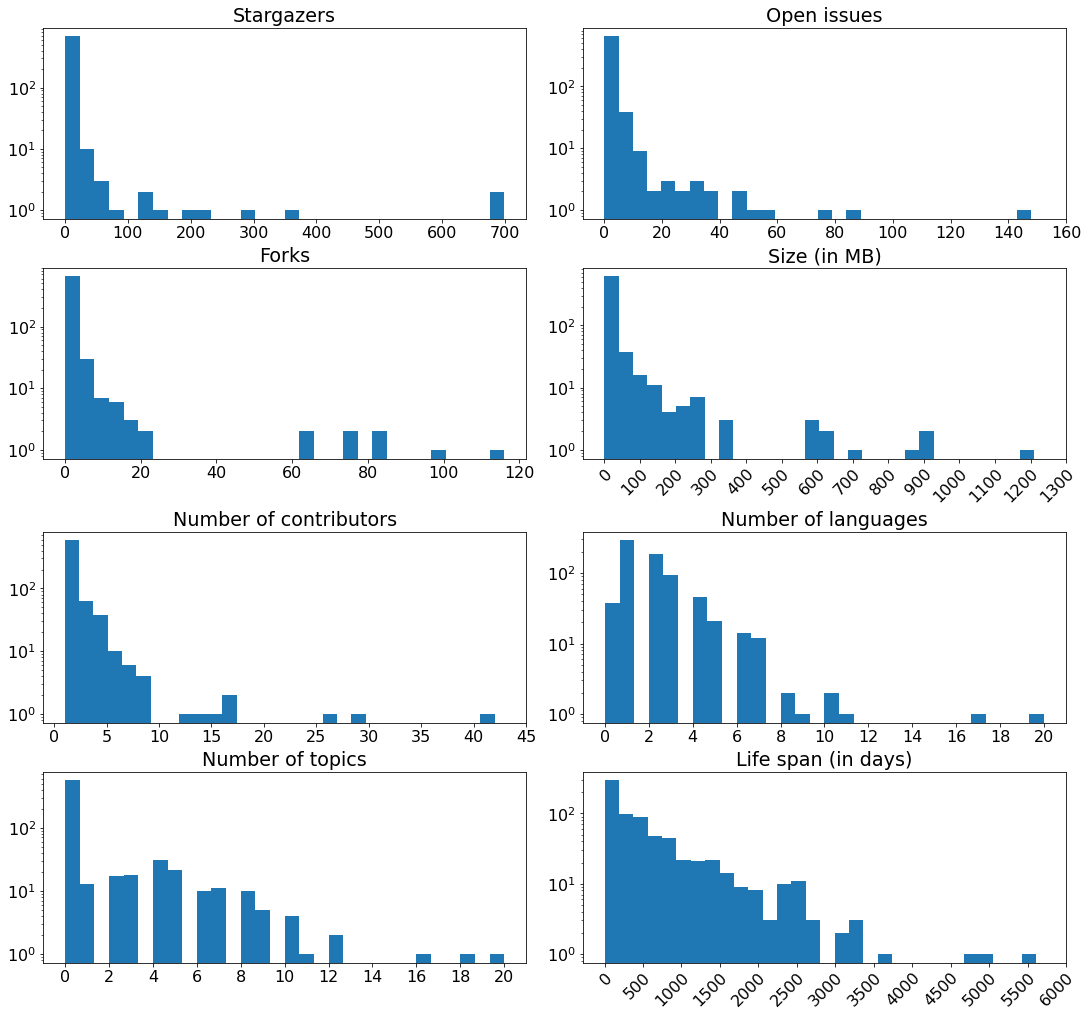

In [52]:
plt.rcParams['figure.figsize'] = [15, 14]
fig, ax = plt.subplots(4, 2, constrained_layout=True)
rotation=45

plot_var = "stargazers_count"
cols = [rs_repos_final[plot_var]]
xticks=100
title="Stargazers"
ax[0,0].hist(cols,bins=30, label=label_non_rs)
ax[0,0].set_yscale("log")
ax[0,0].set_title(title)
ax[0,0].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))
ax[0,0].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))


plot_var = "open_issues"
cols = [rs_repos_final[plot_var]]
xticks=20
title="Open issues"
ax[0,1].hist(cols,bins=30, label=label_non_rs)
ax[0,1].set_yscale("log")
ax[0,1].set_title(title)
ax[0,1].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))
ax[0,1].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))

plot_var = "forks"
cols = [rs_repos_final[plot_var]]
xticks=20
title="Forks"
ax[1,0].hist(cols,bins=30, label=label_non_rs)
ax[1,0].set_yscale("log")
ax[1,0].set_title(title)
ax[1,0].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))
ax[1,0].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks))


plot_var = "size"
cols = [rs_repos_final[plot_var]]
xticks=100
title="Size (in MB)"
ax[1,1].hist(cols,bins=30, label=label_non_rs)
ax[1,1].set_yscale("log")
ax[1,1].set_title(title)
ax[1,1].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
ax[1,1].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int), 
                        rotation=rotation, ha="right", rotation_mode='anchor')


plot_var = "contributors_count"
cols = [rs_repos_final[plot_var]]
xticks=5
title="Number of contributors"
ax[2,0].hist(cols,bins=30, label=label_non_rs)
ax[2,0].set_yscale("log")
ax[2,0].set_title(title)
ax[2,0].set_xticks(np.arange(0, max(map(max, cols))+xticks, xticks).astype(int))
ax[2,0].set_xticklabels(np.arange(0, max(map(max, cols))+xticks, xticks).astype(int))


plot_var = "languages_count"
cols = [rs_repos_final[plot_var]]
xticks=2
title="Number of languages"
ax[2,1].hist(cols,bins=30, label=label_non_rs)
ax[2,1].set_yscale("log")
ax[2,1].set_title(title)
ax[2,1].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
ax[2,1].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))


plot_var = "topics_count"
cols = [rs_repos_final[plot_var]]
xticks=2
title="Number of topics"
ax[3,0].hist(cols,bins=30, label=label_non_rs)
ax[3,0].set_yscale("log")
ax[3,0].set_title(title)
ax[3,0].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
ax[3,0].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))


plot_var = "life_span"
cols = [rs_repos_final[plot_var]]
xticks=500
title="Life span (in days)"
ax[3,1].hist(cols,bins=30, label=label_non_rs)
ax[3,1].set_yscale("log")
ax[3,1].set_title(title)
ax[3,1].set_xticks(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int))
ax[3,1].set_xticklabels(np.arange(min(map(min, cols)), max(map(max, cols))+xticks, xticks).astype(int), 
                        rotation=rotation, ha="right", rotation_mode='anchor')


# plt.tight_layout()
plt.savefig(Path(fp_figs, f'stats_histograms_rs_only.png'))

### Kruskal-wallis and Dunn's tests

In [53]:
# stats.kruskal

# get all dataframes per faculty
df_faculties = []
faculties = []
for faculty, df_faculty in rs_repos_final.groupby('faculty'):
    df_faculties.append(df_faculty)
    faculties.append(faculty)
    
    
# for each variable, get all faculty numbers. 8x5 lists
var_list_of_lists = []
for variable in numeric_variables:
    var_list_per_faculty = []
    for faculty in df_faculties:
        var_list_per_faculty.append(faculty[variable])
    var_list_of_lists.append(var_list_per_faculty)
    
results = []
for var_list in var_list_of_lists:
    results.append(stats.kruskal(*var_list))
    
    
result_kw = []
pvalue_threshold = 0.05
for variable, result in zip(numeric_variables,results):
    print(f"Variable: {variable}\n\t\
    P-value: {result.pvalue:.20f}\n\t\
    Statistically significant? {result.pvalue < pvalue_threshold}")
    result_kw.append([variable, result.pvalue, result.pvalue < pvalue_threshold])

Variable: stargazers_count
	    P-value: 0.00000001247648930693
	    Statistically significant? True
Variable: open_issues
	    P-value: 0.00000651357094235392
	    Statistically significant? True
Variable: forks
	    P-value: 0.00000000130139999892
	    Statistically significant? True
Variable: size
	    P-value: 0.00031124210441742803
	    Statistically significant? True
Variable: contributors_count
	    P-value: 0.00003651741890787958
	    Statistically significant? True
Variable: languages_count
	    P-value: 0.01750939393949491399
	    Statistically significant? True
Variable: topics_count
	    P-value: 0.00000000001668033154
	    Statistically significant? True
Variable: life_span
	    P-value: 0.27694943408256311734
	    Statistically significant? False


In [54]:
df_result_kw = pd.DataFrame(result_kw, columns=["Variable","p-value","Significant?"])

df_result_kw.to_latex(Path(fp_tables, "stats_kruskal_wallis.tex"),
                      column_format = "lccc",
                      label = f"tab:kruskal_wallis",
                      caption=f"Kruskal-Wallis test results")
df_result_kw

,Variable,p-value,Significant?
0,stargazers_count,1.247649e-08,True
1,open_issues,6.513571e-06,True
2,forks,1.301400e-09,True
3,size,3.112421e-04,True
4,contributors_count,3.651742e-05,True
5,languages_count,1.750939e-02,True
6,topics_count,1.668033e-11,True
7,life_span,2.769494e-01,False


In [55]:
cmap_uniform = sns.color_palette("blend:#429f8c,#429f8c", as_cmap=True)
# for p-values less than minimum
cmap_uniform.set_under("#9f4255")

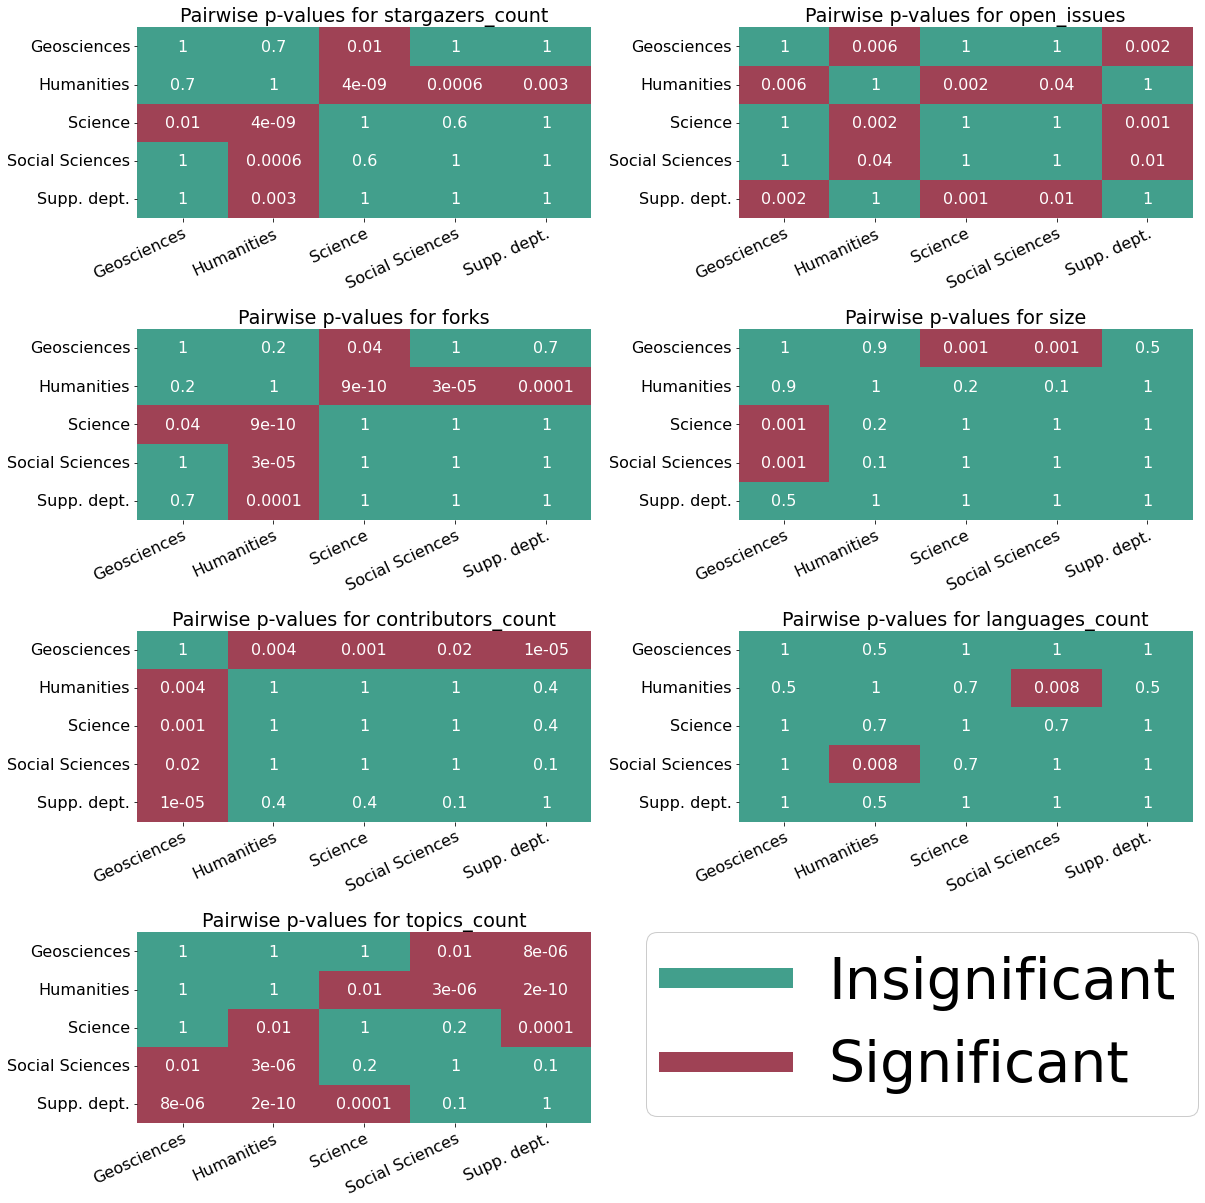

In [56]:
results_posthoc = []
# exclude life span since it's not statistically significant
numeric_variables_posthoc = [var for var in numeric_variables if var != "life_span"] 
for var in numeric_variables:
    df_result = sp.posthoc_dunn(rs_repos_final, 
                                val_col=var, 
                                group_col="faculty", 
                                p_adjust="bonferroni")
    df_result.rename(columns={"Support departments": "Supp. dept."},
                     index={"Support departments": "Supp. dept."},
                     inplace=True)
    results_posthoc.append(df_result)


plt.rcParams['figure.figsize'] = [17, 17]
fig, ax = plt.subplots(4, 2)
var_plot_counter = 0

for ax_row in ax:
    for ax_plot in ax_row:
        if var_plot_counter <= 6:
            var = numeric_variables_posthoc[var_plot_counter]
            df_result = results_posthoc[var_plot_counter]

            title = f"Pairwise p-values for {var}"
            s = sns.heatmap(df_result, 
                            annot=True, 
                            cmap=cmap_uniform,
                            vmin=0.05,
                            ax=ax_plot,
                            cbar=False,
                            fmt='.0g')
            s.set(title=title, xlabel=xlabel, ylabel=ylabel)
            s.set_xticklabels(s.get_xticklabels(),rotation = 25, ha="right", rotation_mode='anchor')
            var_plot_counter += 1
        else:
            custom_lines = [plt.Line2D([0], [0], color=cmap_uniform(.1), lw=20),
                            plt.Line2D([0], [0], color="#9f4255", lw=20)]
            ax_plot.axis("off")
            ax_plot.legend(custom_lines, 
                           ["Insignificant","Significant"], 
                           bbox_to_anchor=(1.075, 1.15),
                           framealpha=1.0,
                           prop={'size': 57})
            
plt.tight_layout()
plt.savefig(Path(fp_figs, f'stats_dunn_pvalues.png'))

Print single heatmap

In [57]:
# plt.rcParams['figure.figsize'] = [8, 6]
# title = f"Pairwise p-values for {var}"
# s = sns.heatmap(df_result, 
#                 annot=True, 
#                 cmap=cmap,
#                 vmin=0.05,
#                 fmt='.0g')
# s.set(title=title, xlabel=xlabel, ylabel=ylabel)
# s.set_xticklabels(s.get_xticklabels(),rotation = 30, ha="right", rotation_mode='anchor')
# plt.tight_layout()

### Logistic regression

In [58]:
scaler = MinMaxScaler()
seed=42

feature_names = numeric_variables + all_boolean_variables
feature_names.remove("howfairis_repository")
repos_logit = repos.loc[repos["howfairis_repository"]==True]
repos_logit = repos_logit.drop("howfairis_repository", axis=1)
repos_logit.reset_index(drop=True, inplace=True)
# repos_logit = repos_logit[feature_names + ["is_rs"]]


scaled = scaler.fit_transform(repos_logit[numeric_variables])
df_scaled_numeric = pd.DataFrame(scaled, columns=numeric_variables)
df_scaled = df_scaled_numeric.join(repos_logit.drop(numeric_variables, axis=1))

X_unscaled = repos_logit[feature_names]
X = df_scaled[feature_names]
y = df_scaled["is_rs"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [59]:
# inspect multicollinearity

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Feature"] = X_unscaled.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_unscaled.values, i) for i in range(len(X_unscaled.columns))]
vif_data_rounded = vif_data.round(2)  
print(vif_data_rounded)

vif_data_rounded.round(2).to_latex(Path(fp_tables, "stats_vif.tex"),
                                   column_format = "lc",
                                   index=False,
                                   label = f"tab:vif",
                                   caption=f"Variance inflation factor values")

                    Feature   VIF
0          stargazers_count  3.87
1               open_issues  2.15
2                     forks  4.46
3                      size  1.23
4        contributors_count  3.29
5           languages_count  2.63
6              topics_count  1.56
7                 life_span  2.36
8         howfairis_license  2.19
9        howfairis_registry  1.41
10       howfairis_citation  1.42
11      howfairis_checklist  1.16
12                vcs_usage  1.10
13              repo_active  1.69
14  has_install_instruction  2.06
15       has_usage_examples  1.76
16   has_contrib_guidelines  1.31
17                 has_test  1.70
18     version_identifiable  1.74


In [60]:
# random search logistic regression model on the sonar dataset
np.random.seed(seed=seed)

# define model
model = LogisticRegression(penalty="l1", solver="liblinear", random_state=seed)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
# define search space
space = dict()
space['C'] = stats.loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed)

# execute search
cv_result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % cv_result.best_score_)
print('Best Hyperparameters: %s' % cv_result.best_params_)

Best Score: 0.6916926342410693
Best Hyperparameters: {'C': 1.2069513145865525}


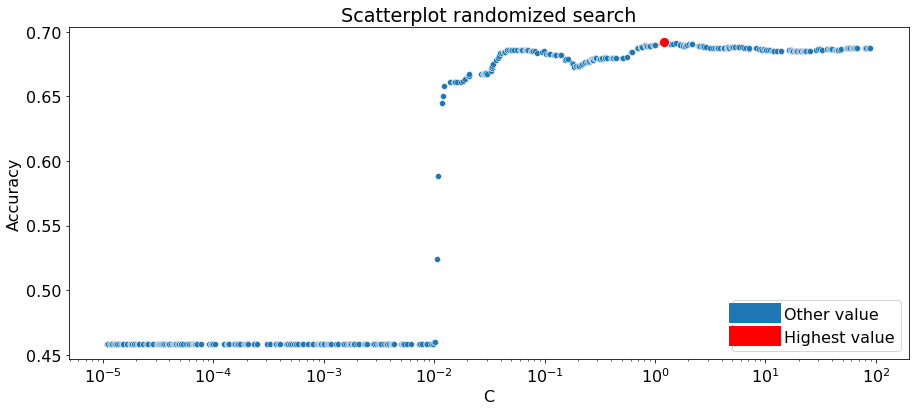

In [61]:
plt.rcParams['figure.figsize'] = [13, 6]
values = []
for alpha, score in zip(cv_result.cv_results_['params'], cv_result.cv_results_['mean_test_score']):
    values.append([alpha["C"], score])
    
values_sorted = sorted(values)
df_search_result = pd.DataFrame(values_sorted, columns=["C", "Accuracy"])

s = sns.scatterplot(x="C", y="Accuracy", data=df_search_result)
s = sns.scatterplot(x=[cv_result.best_params_["C"]], y=[cv_result.best_score_], color="red", s=100)


custom_lines = [plt.Line2D([0], [0], color=sns.color_palette("tab10")[0], lw=20),
                plt.Line2D([0], [0], color="red", lw=20)]
s.legend(custom_lines, ["Other value","Highest value"], loc="lower right")
title = "Scatterplot randomized search"

s.set_xscale("log")
s.set_title(title)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'stats_scatter_randomsearch_logit.png'))

In [62]:
logreg = LogisticRegression(max_iter=1000, 
                            penalty="l1", solver="liblinear", random_state=seed,
                            C=cv_result.best_params_["C"])

logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
score = logreg.score(X_test, y_test)
w = np.array(logreg.coef_).transpose()
chance_pred = np.full((304), True)


print("Accuracy:", score)

Accuracy: 0.625


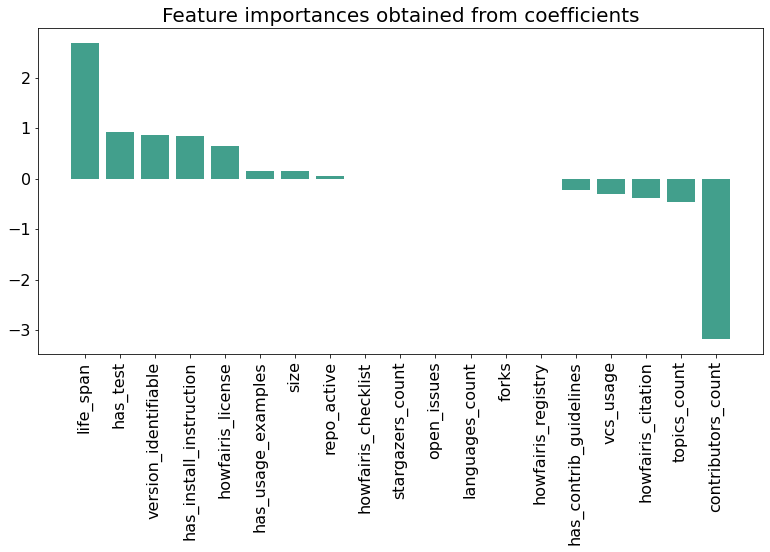

In [63]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color=cmap_color)
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.savefig(Path(fp_figs, f'stats_feature_importance_logit.png'))

### Random forest

In [64]:
np.random.seed(seed=seed)

# define model
model = RandomForestClassifier(random_state=seed)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
# define search space
space = { 
    "n_estimators": [10,100,300,500],
    "max_features": [None, "sqrt", "log2"]
}
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
cv_result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % cv_result.best_score_)
print('Best Hyperparameters: %s' % cv_result.best_params_)

Best Score: 0.7026644989387164
Best Hyperparameters: {'max_features': None, 'n_estimators': 500}


In [65]:
feature_names = X.columns
forest = RandomForestClassifier(random_state=seed, 
                                n_estimators=cv_result.best_params_["n_estimators"],
                                max_features=cv_result.best_params_["max_features"])
forest.fit(X_train, y_train)
pred_forest = forest.predict(X_test)

result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances.sort_values(inplace=True, ascending=False)

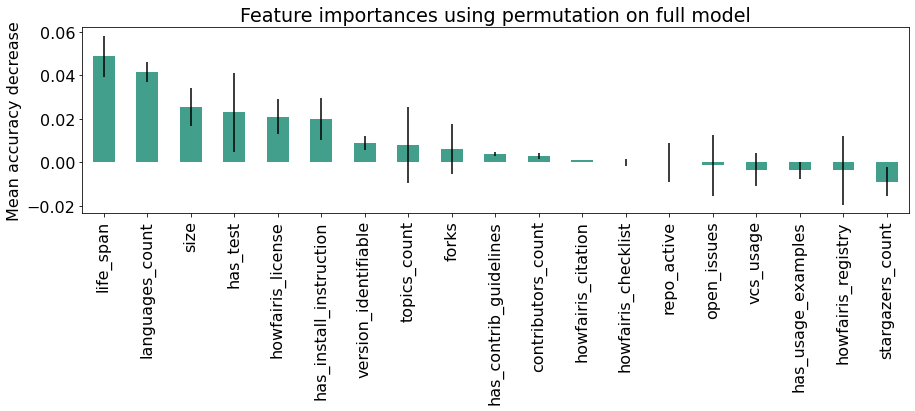

In [66]:
plt.rcParams['figure.figsize'] = [13, 6]

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, color=cmap_color)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.savefig(Path(fp_figs, f'stats_feature_importance_forest.png'))

### Model evaluations

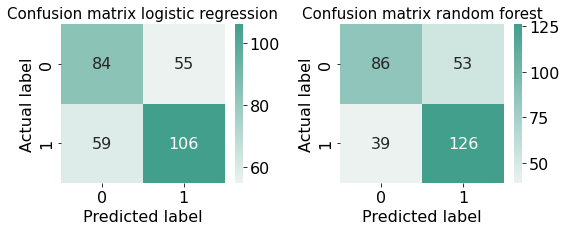

In [67]:
plt.rcParams['figure.figsize'] = [8, 3.5]
fig, ax = plt.subplots(1, 2)


cm = metrics.confusion_matrix(y_test, pred)
cm_chance = metrics.confusion_matrix(y_test, pred_forest)

s = sns.heatmap(cm, annot=True, fmt="g", cmap=cmap, ax=ax[0])
ax[0].set_ylabel('Actual label')
ax[0].set_xlabel('Predicted label')
ax[0].set_title("Confusion matrix logistic regression", size = 15)


s = sns.heatmap(cm_chance, annot=True, fmt="g", cmap=cmap, ax=ax[1])
ax[1].set_ylabel('Actual label')
ax[1].set_xlabel('Predicted label')
ax[1].set_title("Confusion matrix random forest", size = 15)
plt.tight_layout()
plt.savefig(Path(fp_figs, f'stats_confusion_matrices.png'))

In [68]:
def add_scores(ax, feature):
    total = len(feature)
    for feature_value, p in zip(feature, ax.patches):
        
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_y() + p.get_height()+.01
        ax.annotate(round(feature_value,2), (x, y), size = 14)

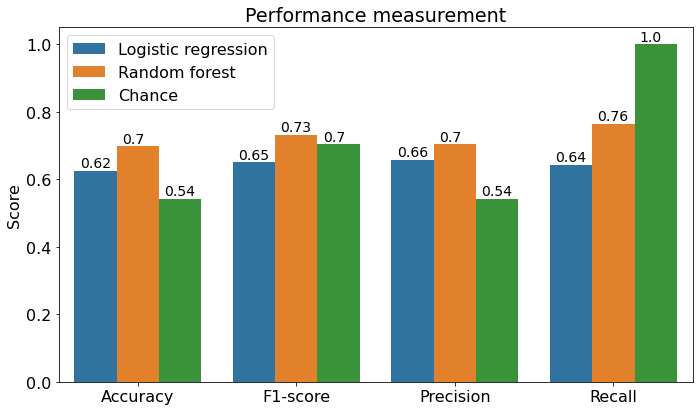

In [69]:
plt.rcParams['figure.figsize'] = [10, 6]
acc = metrics.accuracy_score(y_test, pred)
f1 = metrics.f1_score(y_test, pred)
prec = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)

acc_chance = metrics.accuracy_score(y_test, chance_pred)
f1_chance = metrics.f1_score(y_test, chance_pred)
prec_chance = metrics.precision_score(y_test, chance_pred)
recall_chance = metrics.recall_score(y_test, chance_pred)


acc_forest = metrics.accuracy_score(y_test, pred_forest)
f1_forest = metrics.f1_score(y_test, pred_forest)
prec_forest = metrics.precision_score(y_test, pred_forest)
recall_forest = metrics.recall_score(y_test, pred_forest)


df_scores = pd.DataFrame({
    "Factor": ["Accuracy", "F1-score", "Precision", "Recall"],
    "Logistic regression": [acc, f1, prec, recall],
    "Random forest": [acc_forest, f1_forest, prec_forest, recall_forest],
    "Chance": [acc_chance, f1_chance, prec_chance, recall_chance]
})
fig, ax1 = plt.subplots()
tidy = df_scores.melt(id_vars="Factor").rename(columns=str.title)
s = sns.barplot(x="Factor", y="Value", hue="Variable", data=tidy, ax=ax1)
s.set(title="Performance measurement", xlabel=xlabel, ylabel="Score")

add_scores(s, tidy["Value"])
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(Path(fp_figs, f'stats_barplot_scores_logit.png'))